In [1]:
# source source.me before launching jupyter
# export DWAVE_API_TOKEN=DEV-7dfad1c79ca4cac893a1541f6d04fbb3c2dced5c

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1
%env CUDA_LAUNCH_BLOCKING=1
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1
env: CUDA_LAUNCH_BLOCKING=1
Fri Oct  6 09:29:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 31%   34C    P8     5W / 250W |   4359MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------

In [2]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

In [3]:
import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/CaloQVAE/')

In [4]:
#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[09:29:48.766] INFO   CaloQVAE                                          Willkommen!
[09:29:48.768] INFO   CaloQVAE                                          Loading configuration.


In [5]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_photons = HLF('photon', filename='/fast_scratch/QVAE/data/atlas/binning_dataset_1_photons.xml', wandb=False)
HLF_1_pions = HLF('pion', filename='/fast_scratch/QVAE/data/atlas/binning_dataset_1_pions.xml', wandb=False)
HLF_1_electron = HLF('electron', filename='/fast_scratch/QVAE/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

2023-10-06 09:29:51,669 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[09:29:51.669] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [6]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="configs")

hydra.initialize()

In [7]:


# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/usr/local/lib/python3.8/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[09:29:57.575] INFO   data.dataManager                                  Loading Data


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<KeysViewHDF5 ['energy', 'energy_from_voxels', 'voxels']>
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<KeysViewHDF5 ['energy', 'energy_from_voxels', 'voxels']>
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<KeysViewHDF5 ['energy', 'energy_from_voxels', 'voxels']>
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<KeysViewHDF5 ['energy', 'energy_from_voxels', 'voxels']>
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<KeysViewHDF5 ['energy', 'energy_from_voxels', 'voxels']>
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<KeysViewHDF5 ['energy', 'energy_from_

[09:30:20.229] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f7dcc535d30>: 80000 events, 625 batches
[09:30:20.233] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f7cf43aa430>: 10000 events, 10 batches
[09:30:20.234] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f7b26a05970>: 10000 events, 10 batches
[09:30:25.164] INFO   models.modelCreator                               Initialising Model Type GumBoltAtlasCRBMCNNDCond
2023-10-06 09:30:25,169 dwave.cloud.client.base INFO  MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
[09:30:25.169] INFO   dwave.cloud.client.base                           Using region m

40279 28582
Initializing NetworkV3


In [8]:
config.data

{'data_type': 'atlas', '_layers': ['showers'], 'particle_type': 'electron-ds2', 'dataset': 'dataset2', 'frac_test_dataset': 0.1, 'frac_train_dataset': 0.8, 'particle': 'electron', 'scaled': False, 'scaler_path': '/fast_scratch/QVAE/data/atlas_dataset2and3_scaled/dataset_2_1_scaler.gz', 'scaler_amin': '/fast_scratch/QVAE/data/atlas_dataset2and3_scaled/dataset_2_1_amin.npy', 'atlas_input_photon1': '/fast_scratch/QVAE/data/atlas/photons1.hdf5', 'atlas_input_photonEn0': '/fast_scratch/QVAE/data/atlas/photons_samples_highStat_En_0.hdf5', 'atlas_input_photonEn1': '/fast_scratch/QVAE/data/atlas/photons_samples_highStat_En_1.hdf5', 'atlas_input_photonEn2': '/fast_scratch/QVAE/data/atlas/photons_samples_highStat_En_2.hdf5', 'atlas_input_photonEn3': '/fast_scratch/QVAE/data/atlas/photons_samples_highStat_En_3.hdf5', 'atlas_input_photonEn4': '/fast_scratch/QVAE/data/atlas/photons_samples_highStat_En_4.hdf5', 'atlas_input_photonEn5': '/fast_scratch/QVAE/data/atlas_scaled/photons_samples_highStat_E

In [9]:
#Not printing much useful info at the moment to avoid clutter. TODO optimise
model.print_model_info()
# for name, param in model.named_parameters():
#         print(name, param.requires_grad)

# Load the model on the GPU if applicable
# dev = None
# if (config.device == 'gpu') and config.gpu_list:
#     logger.info('Requesting GPUs. GPU list :' + str(config.gpu_list))
#     devids = ["cuda:{0}".format(x) for x in list(config.gpu_list)]
#     logger.info("Main GPU : " + devids[0])

#     if is_available():
#         print(devids[0])
#         dev = device(devids[0])
#         if len(devids) > 1:
#             logger.info(f"Using DataParallel on {devids}")
#             model = DataParallel(model, device_ids=list(config.gpu_list))
#         logger.info("CUDA available")
#     else:
#         dev = device('cpu')
#         logger.info("CUDA unavailable")
# else:
#     logger.info('Requested CPU or unable to use GPU. Setting CPU as device.')
#     dev = device('cpu')
dev = torch.device("cuda:0")

# Send the model to the selected device
# model.to(dev)
# Log metrics with wandb
wandb.watch(model)

# For some reason, need to use postional parameter cfg instead of named parameter
# with updated Hydra - used to work with named param but now is cfg=None 
engine=instantiate(config.engine, config)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[09:30:43.226] INFO   models.autoencoders.autoencoderbase               _dataset_mean: torch.Size([1, 6480])
[09:30:43.228] INFO   wandb                                             Watching
/usr/local/lib/python3.8/dist-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
[09:30:45.894] INFO   engine.engineAtlas                                Setting up engine Atlas.
[09:30:45.895] INFO   engine.engineCaloV3                               Setting up engine Calo.
[09:30:45.896] INFO   engine.engine                                     Setting up default engine.


In [10]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<KeysViewHDF5 ['energy', 'energy_from_voxels', 'voxels']>
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<KeysViewHDF5 ['energy', 'energy_from_voxels', 'voxels']>
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<KeysViewHDF5 ['energy', 'energy_from_voxels', 'voxels']>
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<KeysViewHDF5 ['energy', 'energy_from_voxels', 'voxels']>
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<KeysViewHDF5 ['energy', 'energy_from_voxels', 'voxels']>
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<KeysViewHDF5 ['energy', 'energy_from_

[09:31:09.017] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f7b2707c730>: 80000 events, 625 batches
[09:31:09.018] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f7b2707c820>: 10000 events, 10 batches
[09:31:09.019] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f7b270e6b50>: 10000 events, 10 batches


[  2.251544    2.5484953 197.9918    ...   1.0888047  83.72231
  28.762794 ]
[  2.12811347   3.86557052 256.26794407 ...   1.32488551 110.36127744
  35.36065782]


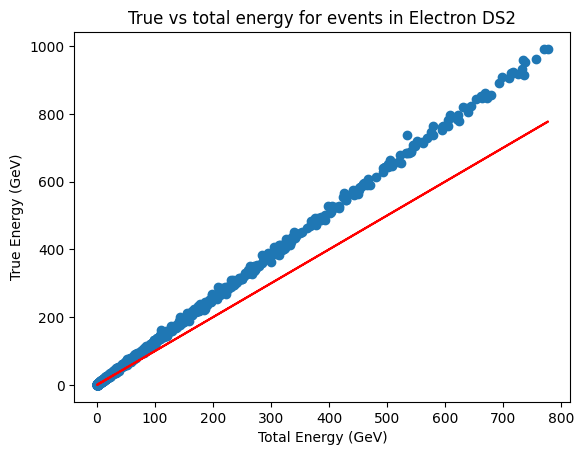

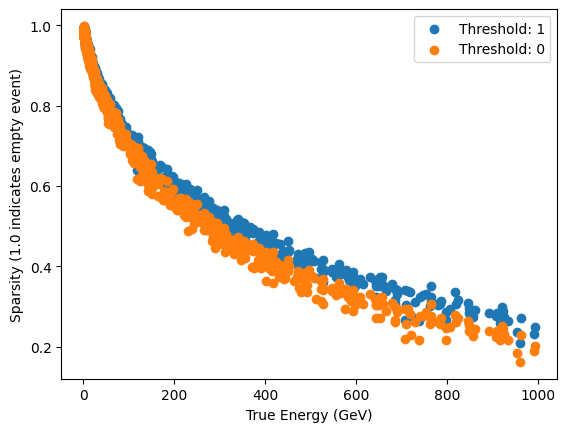

In [11]:
xx = next(iter(val_loader))

voxel_energies = xx[0][0].sum(axis=1).numpy() / 1000
true_energies = xx[1][0].sum(axis=1).numpy() / 1000

print(voxel_energies)
print(true_energies)
plt.scatter(voxel_energies, true_energies)
plt.plot(voxel_energies, voxel_energies, c='red')

plt.xlabel('Total Energy (GeV)')
plt.ylabel('True Energy (GeV)')
plt.title("True vs total energy for events in Electron DS2")
plt.show()
sparsity = (xx[0][0]<1).sum(axis=1) / xx[0][0].size(1)
sparsity_zeroes = (xx[0][0]==0).sum(axis=1) / xx[0][0].size(1)
plt.scatter(true_energies, sparsity, label=f'Threshold: 1')
plt.scatter(true_energies, sparsity_zeroes, label=f'Threshold: 0')
plt.ylabel('Sparsity (1.0 indicates empty event)')
plt.xlabel('True Energy (GeV)')
plt.legend()

In [12]:
xx[0][0][0].size()

torch.Size([6480])

In [13]:
###LOAD MODEL
import h5py

data = h5py.File('/fast_scratch/QVAE/data/atlas_dataset2and3/dataset_2_1.hdf5', 'r')

print(data['showers'][0].sum())
print(data['incident_energies'][0])
print(data.keys())
print(data['showers'])

94183.4972091978
[118329.577806]
<KeysViewHDF5 ['incident_energies', 'showers']>
<HDF5 dataset "showers": shape (100000, 6480), type "<f8">


In [14]:
def load_state(model, run_path, device):
        model_loc = run_path
        
        # Open a file in read-binary mode
        with open(model_loc, 'rb') as f:
            # Interpret the file using torch.load()
            checkpoint=torch.load(f, map_location=device)
            
            local_module_keys=list(model._modules.keys())
            for module in checkpoint.keys():
                if module in local_module_keys:
                    print("Loading weights for module = ", module)
                    getattr(model, module).load_state_dict(checkpoint[module])

In [15]:
# vocal-lake-17
run_path = "/home/sgonzalez/CaloQVAE/outputs/2023-10-03/16-37-07/wandb/run-20231003_163712-2iqfkxfc/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
modelname = 'denim-moon-1335'
datascaled = 'scaled'

with open("/home/sgonzalez/CaloQVAE/outputs/2023-10-03/16-37-07/wandb/run-20231003_163712-2iqfkxfc/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False




arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
load_state(model, run_path, dev)
model.eval();

GumBoltAtlasCRBMCNNDCond
electron-ds2
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
Loading weights for module =  sampler


In [16]:
model_config["_content"]["value"]["reducedata"]

'True'

In [17]:
xx = next(iter(train_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label
xx[0][0][0].sum()
#xx[1][0][0]

tensor(1723.9348)

torch.Size([128, 6480])


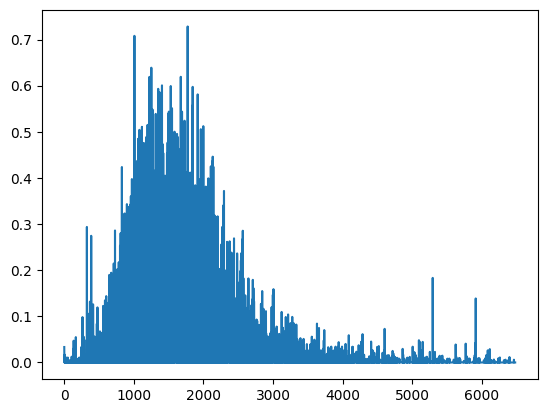

In [18]:
print(in_data.shape)
plt.plot(in_data.cpu().numpy()[3,:])

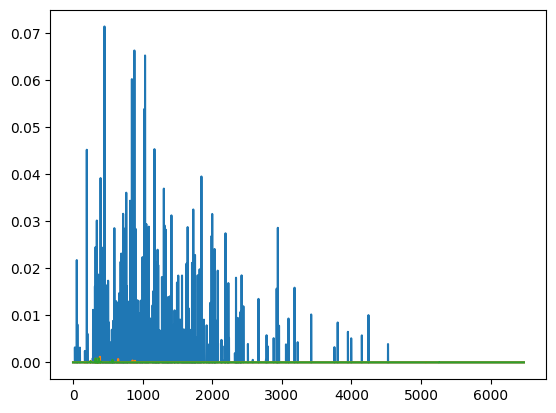

In [19]:
with torch.no_grad():
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    # if reducedata:
    #     in_data = engine._reduce(in_data, true_energy, R=R)
    fwd_output = engine.model((in_data, true_energy), True)
    engine._model.sampler._batch_size = true_energy.shape[0]
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
idx = 100
plt.plot(in_data.cpu().numpy()[idx,:])
plt.plot(fwd_output.output_activations.detach().cpu().numpy()[idx,:])
plt.plot(sample_data.detach().cpu().numpy()[idx,:])

In [20]:
engine._config.model.mapping.lower()

'bipartite'

In [21]:
# enIn = torch.cat((in_data, true_energy), dim=1)
# beta, post_logits, post_samples = engine.model.encoder(enIn)
with torch.no_grad():
    # enIn = torch.cat((in_data, true_energy), dim=1)
    # beta, post_logits, post_samples = engine.model.encoder(enIn)
    beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy)
# plt.plot(post_samples[0][0,:].detach().cpu().numpy())
# post_samples = torch.cat(post_samples, 1)

<class 'list'>
<class 'torch.Tensor'>
<class 'list'>


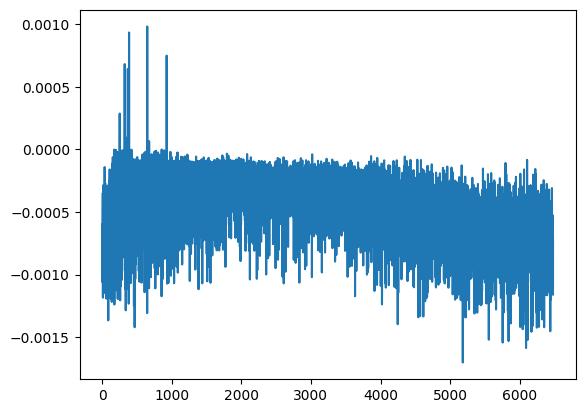

In [22]:
# post_samples = torch.cat([post_samples, true_energy], dim=1)
# output_hits, output_activations = engine.model.decoder(post_samples)
print(type(post_samples))
print(type(beta))
print(type(post_logits))
post_samples = torch.cat(post_samples,1)
output_hits, output_activations = engine.model.decoder(post_samples, true_energy)
plt.plot(output_activations[idx,:].detach().cpu().numpy())


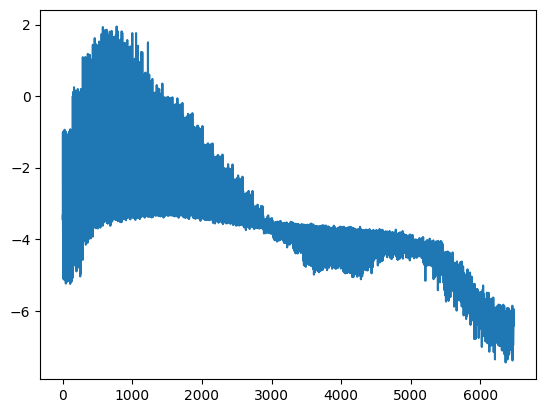

In [23]:
# self._hit_smoothing_dist_mod(output_hits, beta, is_training)
plt.plot(output_hits[1,:].detach().cpu().numpy())
beta = torch.tensor(5, dtype=torch.float, device=output_hits.device, requires_grad=False)

In [24]:
beta = torch.tensor(1, dtype=torch.float, device=output_hits.device, requires_grad=False)

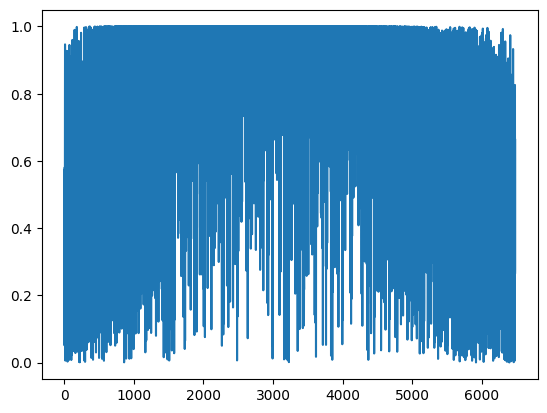

In [25]:
plt.plot(engine.model._hit_smoothing_dist_mod(output_hits, beta, True)[2,:].detach().cpu().numpy())

In [26]:
# for i in range(1,100):
#     print(533 % i, i, 533/i)

In [27]:
# sample_energies
engine._config.engine.cl_lambda

0

In [28]:
rbm_visible_samples, rbm_hidden_samples = engine._model.sampler.block_gibbs_sampling()
rbm_vis = rbm_visible_samples.detach()
rbm_hid = rbm_hidden_samples.detach()
rbm_vis.size()


torch.Size([128, 1000])

In [29]:
# true_energy
# rbm_vis.device
engine._model.sampler

training: False
_parameters: OrderedDict()
_buffers: OrderedDict()
_non_persistent_buffers_set: set()
_backward_pre_hooks: OrderedDict()
_backward_hooks: OrderedDict()
_is_full_backward_hook: None
_forward_hooks: OrderedDict()
_forward_pre_hooks: OrderedDict()
_state_dict_hooks: OrderedDict()
_load_state_dict_pre_hooks: OrderedDict()
_load_state_dict_post_hooks: OrderedDict()
_modules: OrderedDict([('_RBM', QimeraRBM(
  (_weight_dict): ParameterDict(
      (01): Parameter containing: [torch.cuda.FloatTensor of size 1000x1000 (GPU 0)]
      (02): Parameter containing: [torch.cuda.FloatTensor of size 1000x1000 (GPU 0)]
      (03): Parameter containing: [torch.cuda.FloatTensor of size 1000x1000 (GPU 0)]
      (12): Parameter containing: [torch.cuda.FloatTensor of size 1000x1000 (GPU 0)]
      (13): Parameter containing: [torch.cuda.FloatTensor of size 1000x1000 (GPU 0)]
      (23): Parameter containing: [torch.cuda.FloatTensor of size 1000x1000 (GPU 0)]
  )
  (_bias_dict): ParameterDict(


In [30]:
(torch.ones((rbm_vis.size(0), 1), device=rbm_vis.device).detach() * true_energy).shape

torch.Size([128, 1])

In [31]:
en_labels = []

xtarget_samples = []
xrecon_samples = []
xgen_samples = []
xgen_energies = []
true_energies = []

labelstarget_samples = []
labelsrecon_samples = []

for xx in val_loader:
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    
    '''
    new_data = torch.tensor([], device=dev)
    new_e = torch.tensor([], device=dev)
    
    base = 0
    diff = 400000
    for data, true_e in zip(in_data, true_energy):
            if true_e<(base+diff) and true_e>base:
                new_data = torch.cat((new_data, data.view(1, 6480)), dim=0)
                new_e = torch.cat((new_e, true_e.view(1,1)), dim=0)
    in_data = new_data
    true_energy = new_e
    
    if (in_data.size() == torch.Size([0])):
        continue
        
    num_samples = 500
    '''


    if reducedata:
        in_data = engine._reduce(in_data, true_energy, R=R)
    fwd_output = engine.model((in_data, true_energy), False)
    
    if reducedata: #That
        in_data = engine._reduceinv(in_data, true_energy, R=R)
        recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
        engine._model.sampler._batch_size = true_energy.shape[0]
        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy) #engine._model.generate_samples(num_samples=num_samples, true_energy=base+ (diff*torch.rand((num_samples, 1), device=dev))) #
        engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
        sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
    elif scaled:
        in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
        recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
        engine._model.sampler._batch_size = true_energy.shape[0]
        # try:
        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
        # except:
            # pass
        engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
        # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
        sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))

    # xrecon_samples.append( torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy())) )
    if engine._config.engine.cl_lambda:
        labelsrecon_samples.append(fwd_output.labels.detach().cpu())
        labelstarget_samples.append( nn.functional.one_hot(true_energy.divide(256).log2().to(torch.int64), num_classes=15).squeeze(1).to(torch.float).detach().cpu() )
    
        en_labels.append(true_energy.detach().cpu())
    
    xtarget_samples.append(in_data.detach().cpu())
    xrecon_samples.append( recon_data.detach().cpu())
    xgen_samples.append( sample_data.detach().cpu())
    xgen_energies.append( sample_energies.detach().cpu())
    true_energies.append(true_energy.detach().cpu())
    
    # xtarget_samples.append( torch.tensor(engine._data_mgr.inv_transform(xx[0][0].detach().cpu().numpy())) )
    
    
xtarget_samples = torch.cat(xtarget_samples, dim=0)
xrecon_samples = torch.cat(xrecon_samples, dim=0)
xgen_samples = torch.cat(xgen_samples, dim=0)
xgen_energies = torch.cat(xgen_energies, dim=0)
true_energies = torch.cat(true_energies, dim=0)

if engine._config.engine.cl_lambda:
    labelstarget_samples = torch.cat(labelstarget_samples, dim=0)
    labelsrecon_samples = torch.cat(labelsrecon_samples, dim=0)
    en_labels = torch.cat(en_labels, dim=0)

    lhat = torch.argmax(nn.Sigmoid()(labelsrecon_samples), dim=1).numpy()
    l = torch.argmax(labelstarget_samples, dim=1).numpy()


REDUCED
REDUCED
REDUCED
REDUCED
REDUCED
REDUCED
REDUCED
REDUCED
REDUCED
REDUCED


(array([  66.,  232.,  266.,  240.,  237.,  238.,  236.,  224.,  256.,
         261.,  290.,  355.,  292.,  337.,  390.,  422.,  532.,  716.,
        1047., 3363.]),
 array([0.1742284 , 0.21371914, 0.25320989, 0.29270062, 0.33219135,
        0.37168211, 0.41117284, 0.45066357, 0.49015433, 0.52964509,
        0.56913579, 0.60862654, 0.6481173 , 0.687608  , 0.72709876,
        0.76658952, 0.80608022, 0.84557098, 0.88506174, 0.92455244,
        0.9640432 ]),
 [<matplotlib.patches.Polygon at 0x7f8d85f80580>])

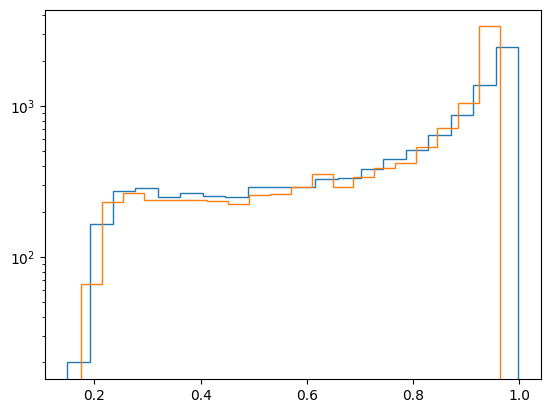

In [32]:
# (l == lhat).sum() / l.shape[0]
#xgen_energies.size()
plt.hist(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step')
plt.hist(((xrecon_samples == 0).sum(dim=1)/xrecon_samples.shape[1]).numpy(), bins=20, log=True, histtype='step')
#plt.hist(true_energies.numpy()/1000, bins=50, log=True, histtype='step', density=True)
#plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=50, log=True, histtype='step', density=True)

In [35]:
(xgen_samples.sum(dim=0) == 0).sum()
#xgen_samples.sum(dim=1).size()

tensor(3328)

gen
0


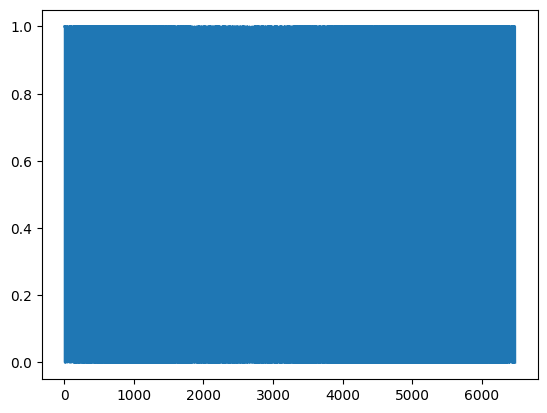

In [36]:

# # (xrecon_samples.sum(dim=1) == 0)[0].item()
# for i, iszero in enumerate(xrecon_samples.sum(dim=0) == 0):
#     if iszero:
#         print(i)
# print("gen")        
# for i, iszero in enumerate(xgen_samples.sum(dim=0) == 0):
#     if iszero:
#         print(i)

l1 = 0
for i, iszero in enumerate(xtarget_samples.sum(dim=0) == 0):
    if iszero:
        # print(i)
        l1 +=1

l2 = []
for i, iszero in enumerate(xrecon_samples.sum(dim=0) == 0):
    if iszero:
        # print(i)
        # l2 +=1
        l2.append(1)
    else:
        l2.append(0)
print("gen") 
l3 = []
for i, iszero in enumerate(xgen_samples.sum(dim=0) == 0):
    if iszero:
        # l3+=1
        l3.append(1)
    else:
        l3.append(0)
    
print(l1)
plt.plot(l2)
# plt.plot(l3)
plt.show()

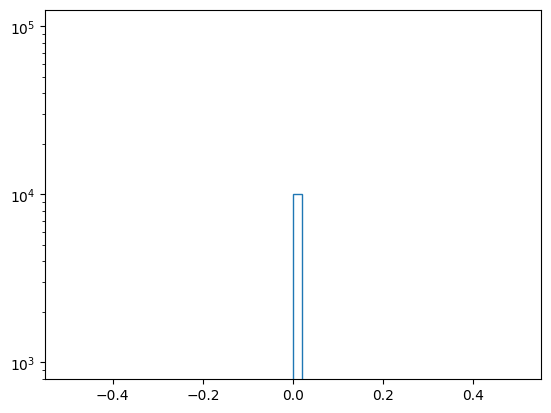

In [37]:
idx = 1
plt.hist(xrecon_samples[:,idx], bins=50, log=True, histtype='step')
plt.show()

In [38]:
xtarget_samples.shape[1]

6480

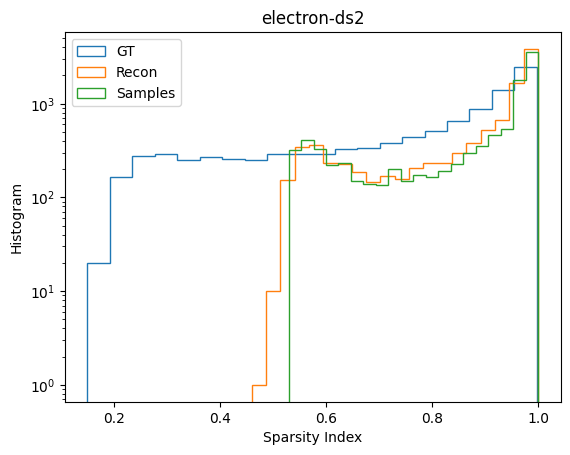

In [39]:
plt.hist(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step')
plt.hist(((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step')
plt.hist(((xgen_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step')
plt.xlabel("Sparsity Index")
plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Samples"])
plt.title(f'{part}')
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [37]:
# np.exp(8)
# torch.abs(torch.sign(engine.model.sampler._RBM.weights))[:10,:10]

In [38]:
# plt.hist(engine.model.sampler._RBM.visible_bias.detach().cpu().numpy())
# plt.hist(engine.model.sampler._RBM.hidden_bias.detach().cpu().numpy())
# plt.hist(engine.model.sampler._RBM.weights.detach().cpu().numpy().reshape(500*500))
# plt.show()
# plt.plot(engine.model.sampler._RBM.weights.detach().cpu().numpy().reshape(500*500))


Layer  0 144  voxels


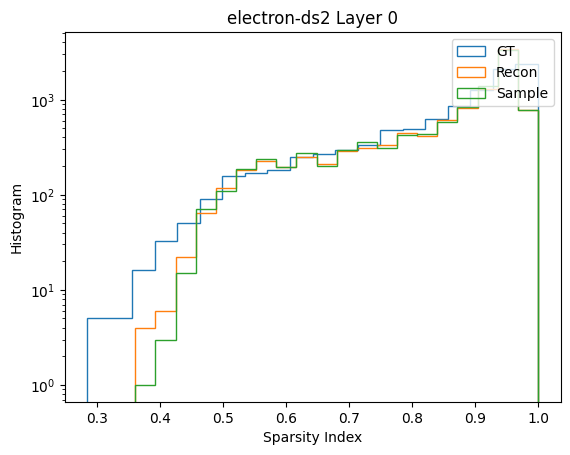

Layer  1 144  voxels


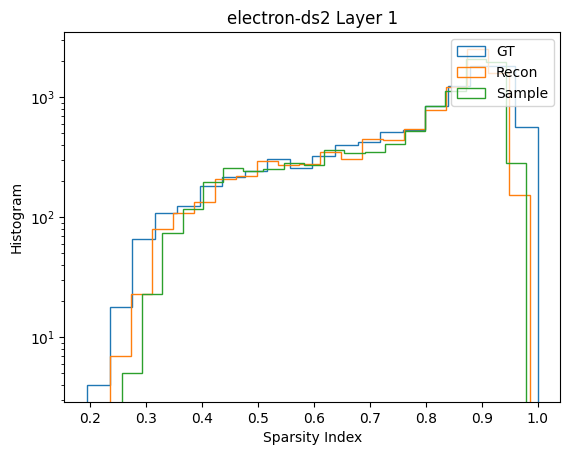

Layer  2 144  voxels


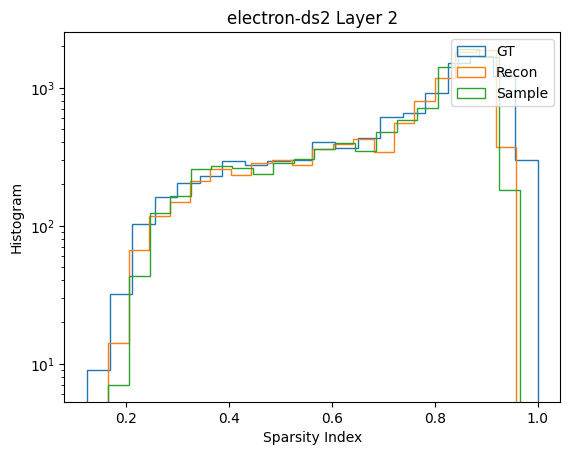

Layer  3 144  voxels


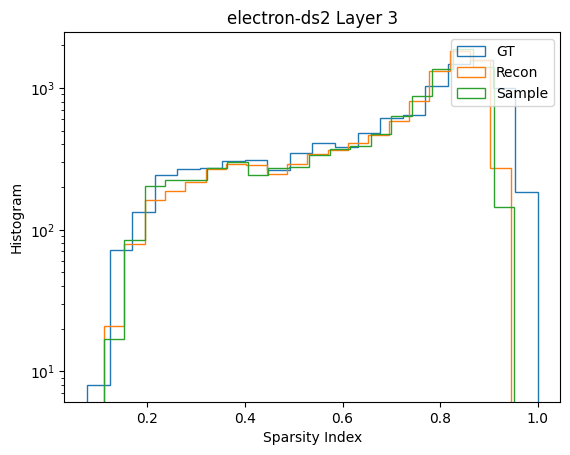

Layer  4 144  voxels


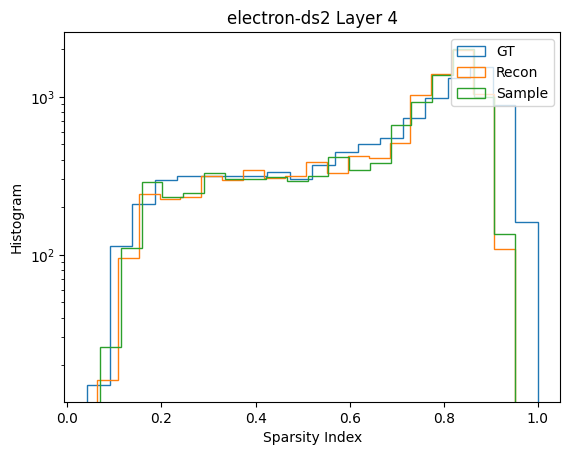

Layer  5 144  voxels


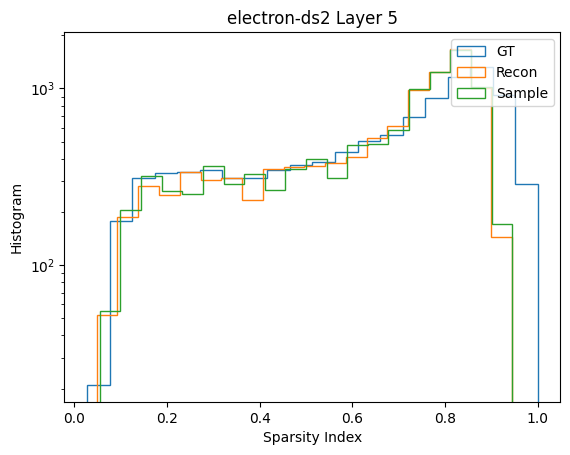

Layer  6 144  voxels


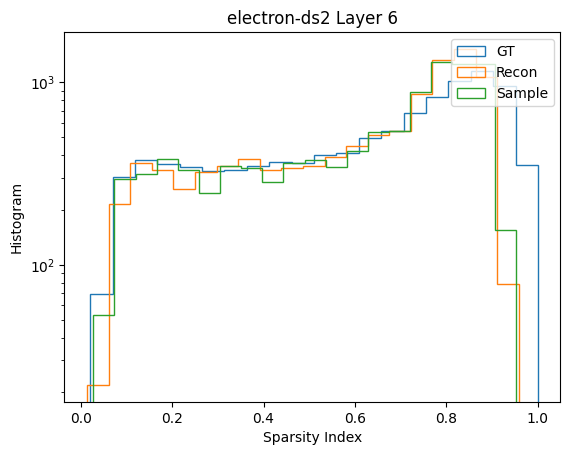

Layer  7 144  voxels


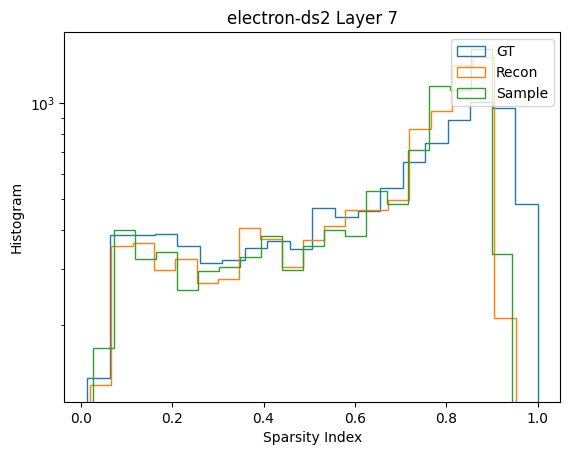

Layer  8 144  voxels


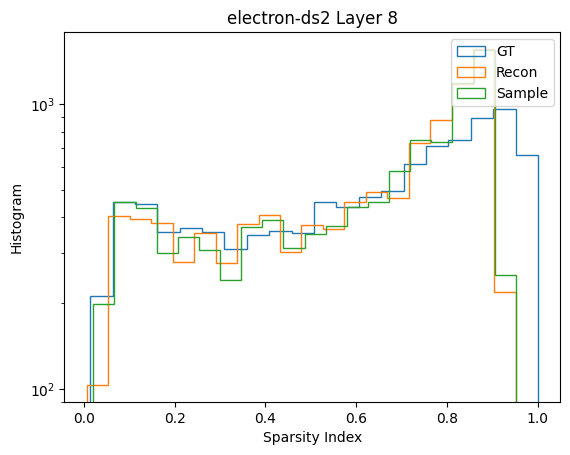

Layer  9 144  voxels


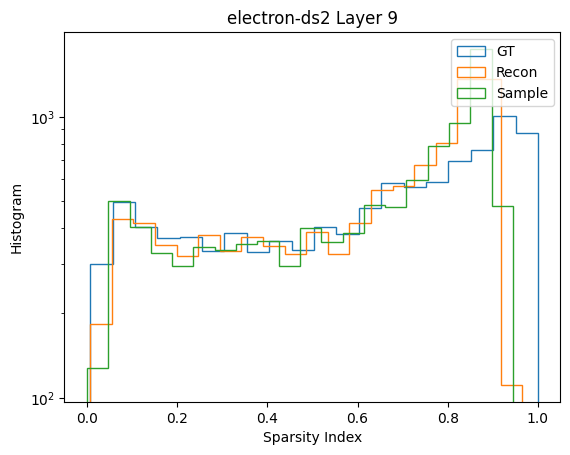

Layer  10 144  voxels


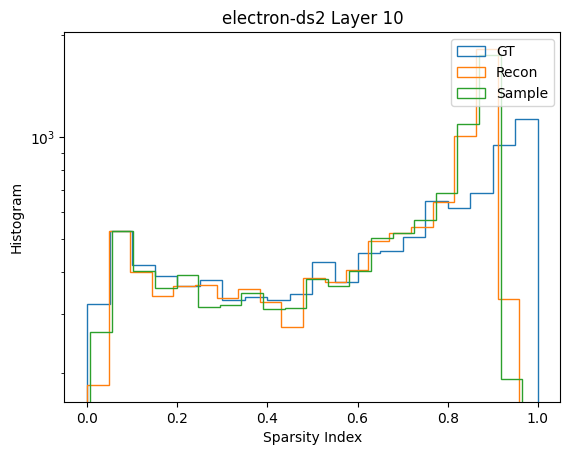

Layer  11 144  voxels


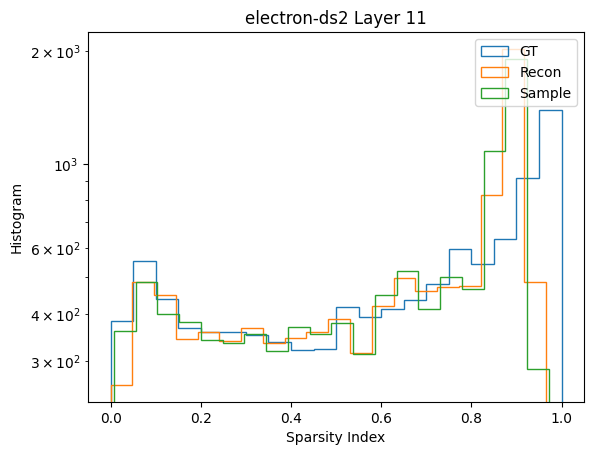

Layer  12 144  voxels


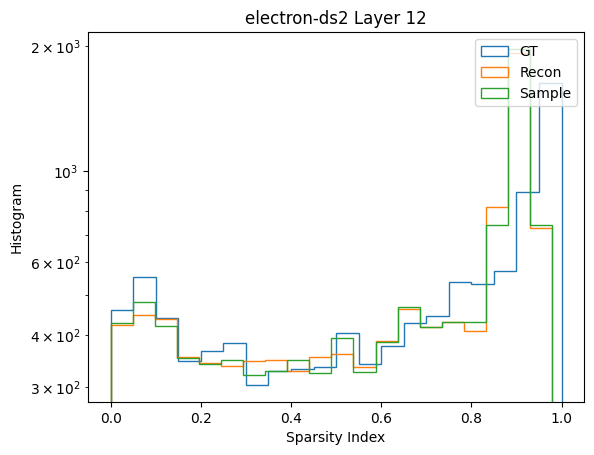

Layer  13 144  voxels


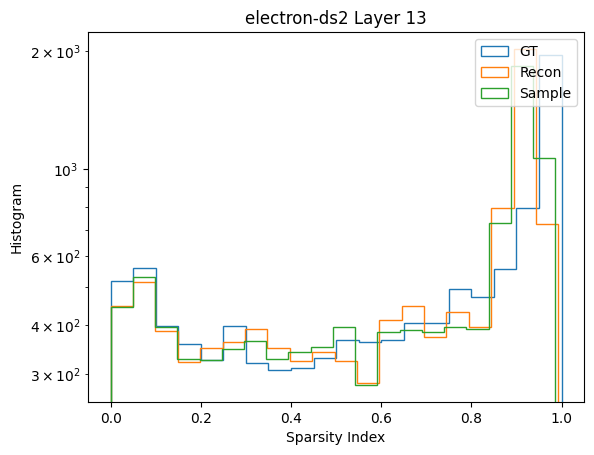

Layer  14 144  voxels


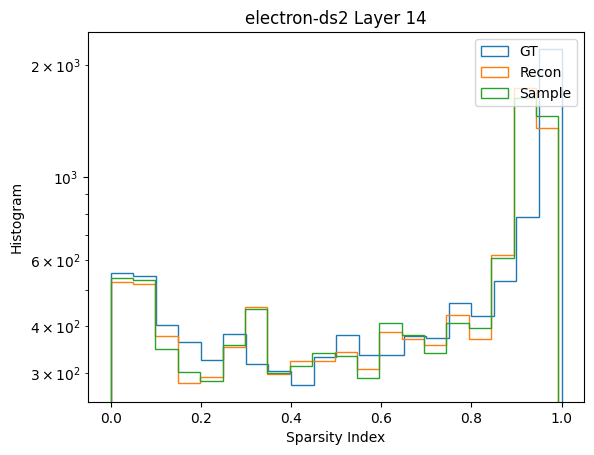

Layer  15 144  voxels


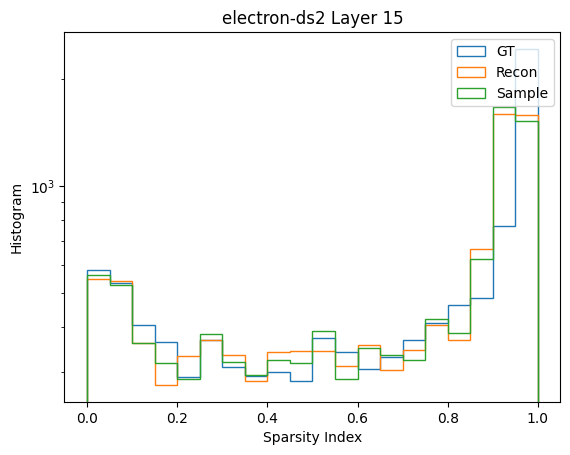

Layer  16 144  voxels


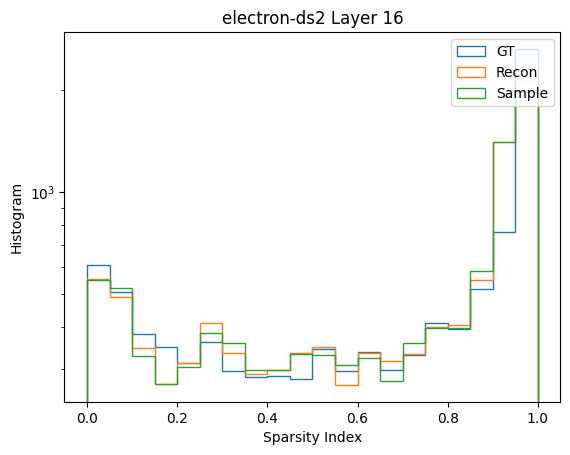

Layer  17 144  voxels


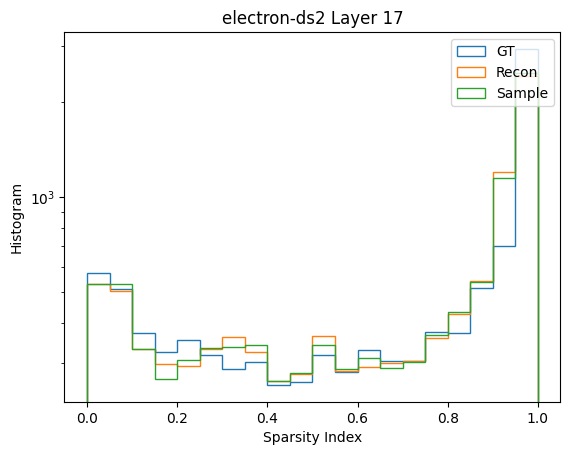

Layer  18 144  voxels


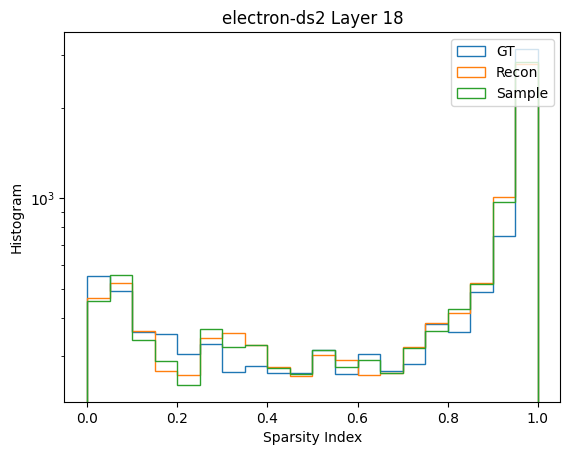

Layer  19 144  voxels


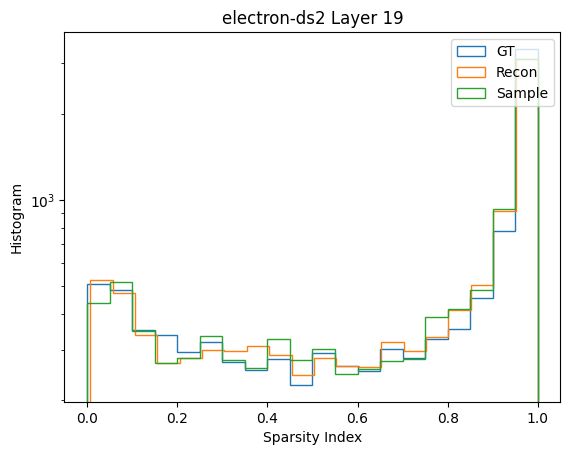

Layer  20 144  voxels


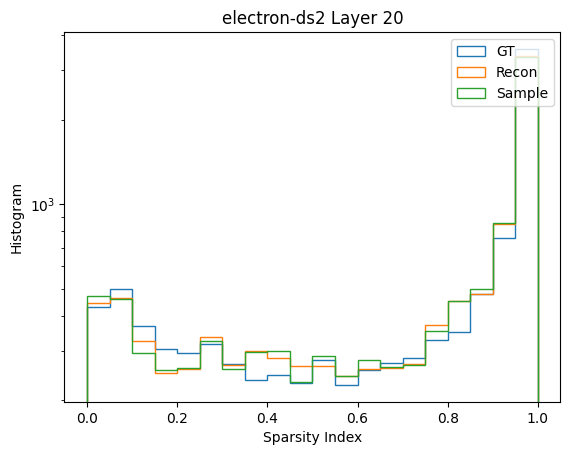

Layer  21 144  voxels


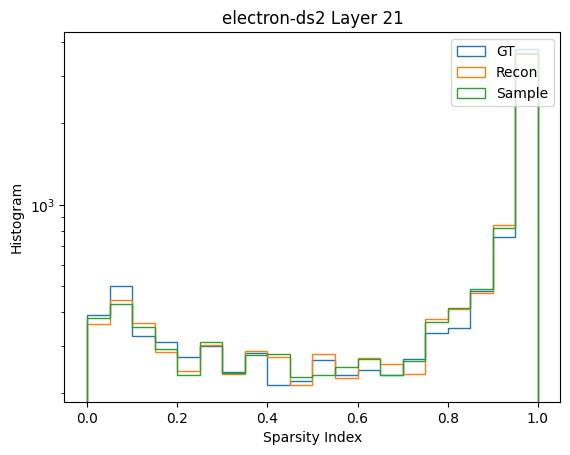

Layer  22 144  voxels


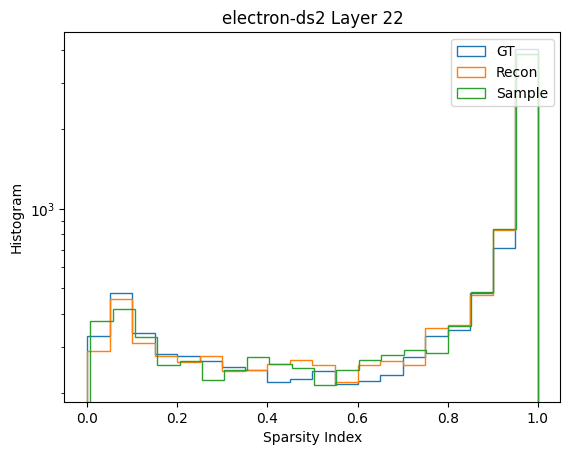

Layer  23 144  voxels


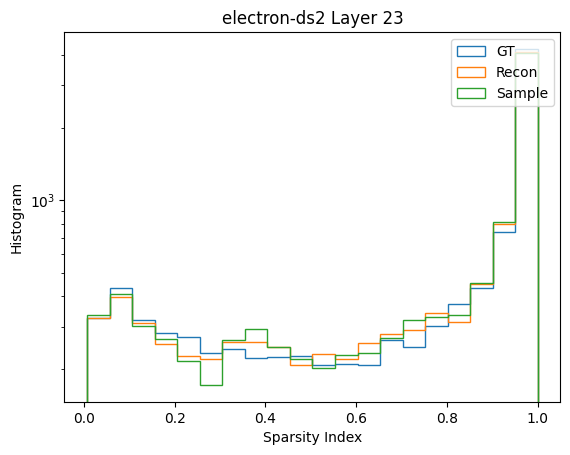

Layer  24 144  voxels


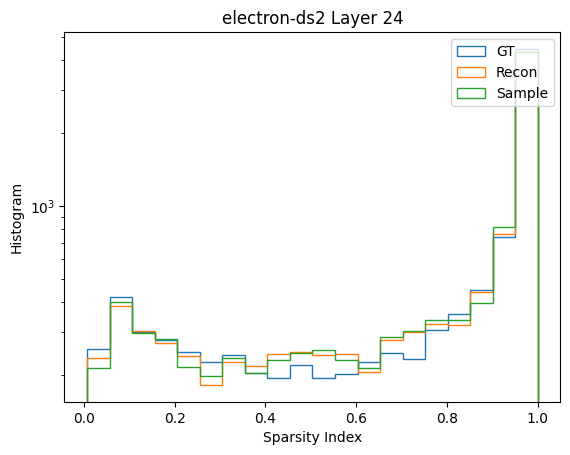

Layer  25 144  voxels


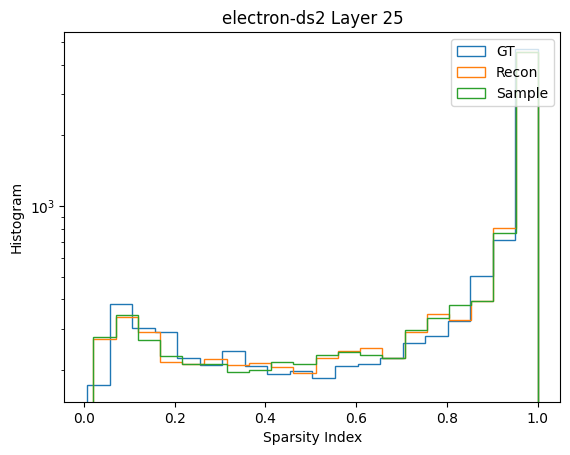

Layer  26 144  voxels


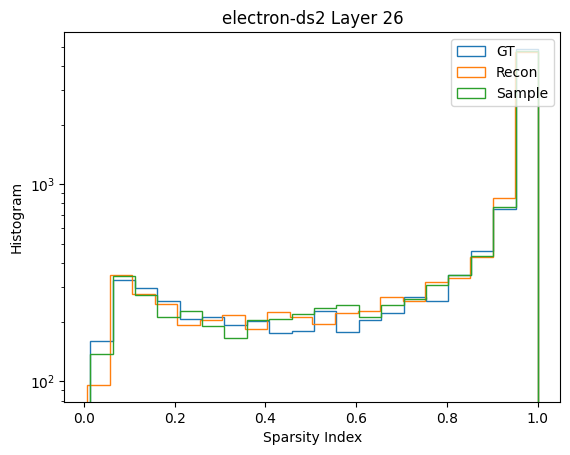

Layer  27 144  voxels


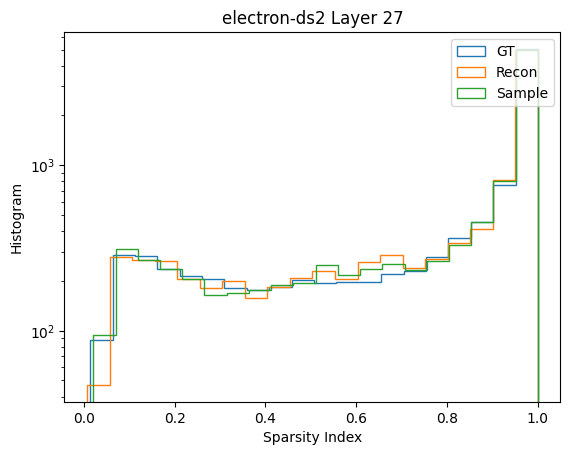

Layer  28 144  voxels


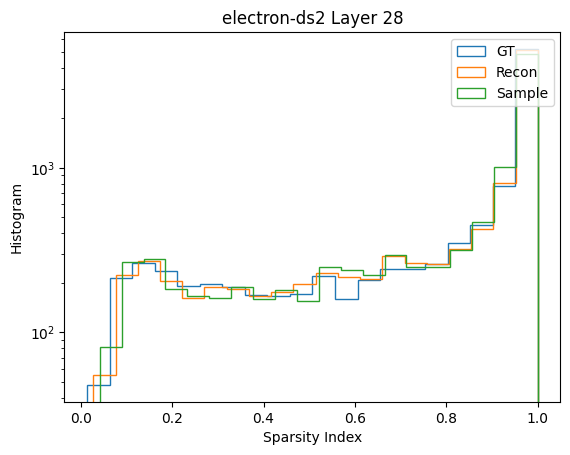

Layer  29 144  voxels


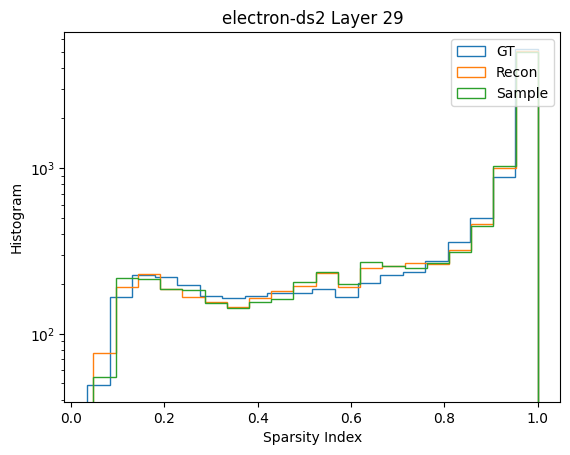

Layer  30 144  voxels


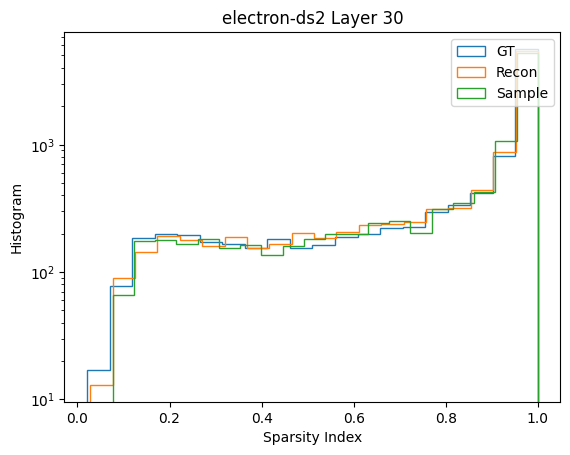

Layer  31 144  voxels


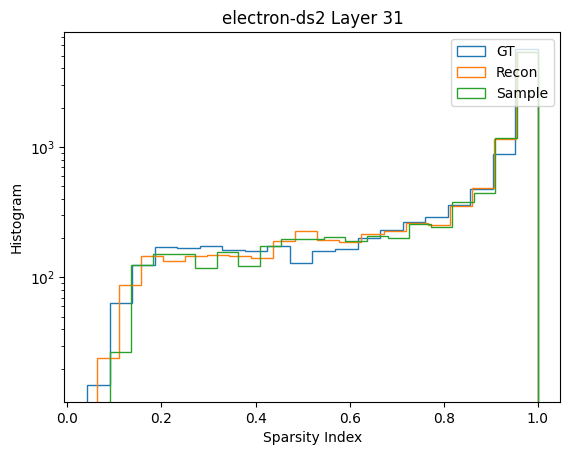

Layer  32 144  voxels


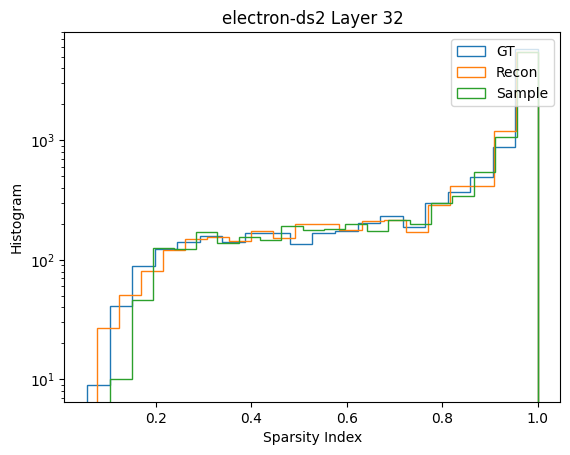

Layer  33 144  voxels


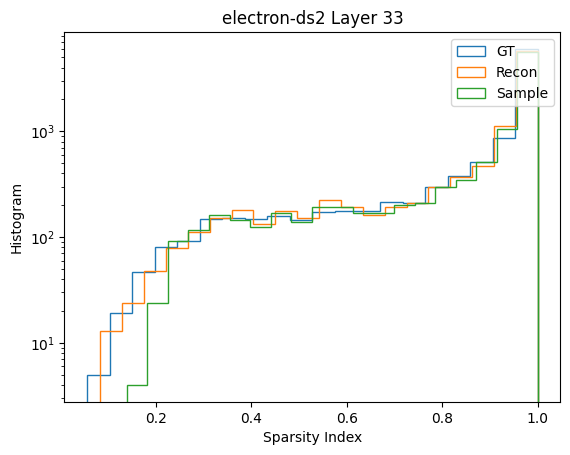

Layer  34 144  voxels


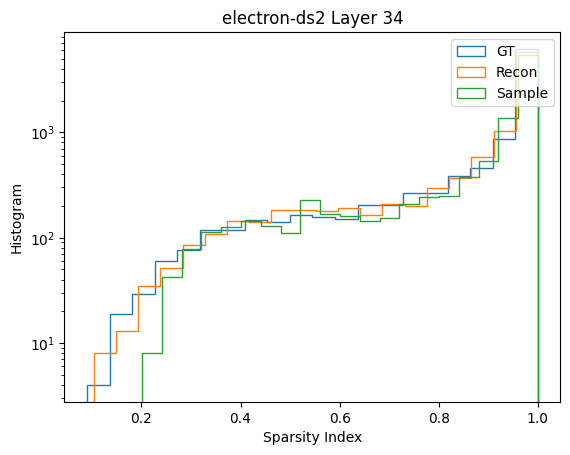

Layer  35 144  voxels


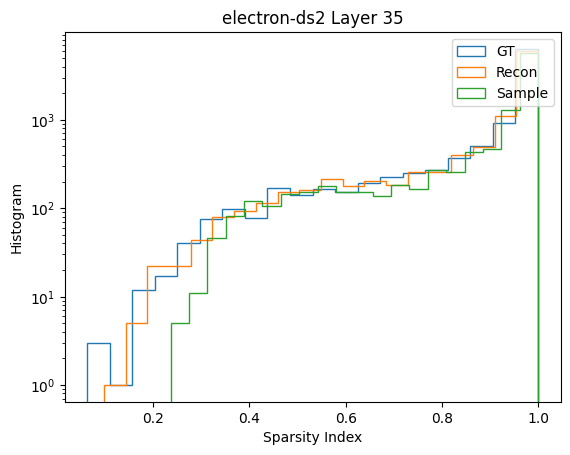

Layer  36 144  voxels


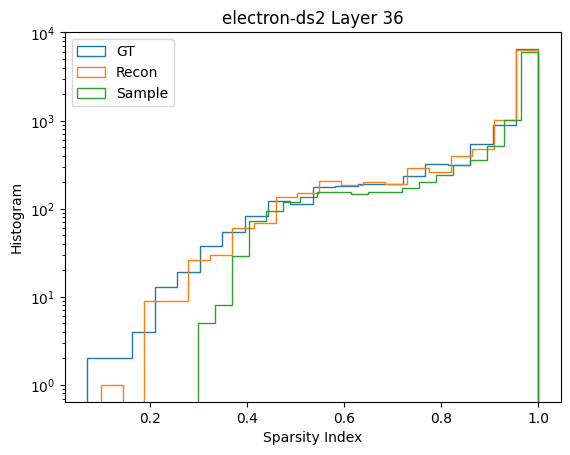

Layer  37 144  voxels


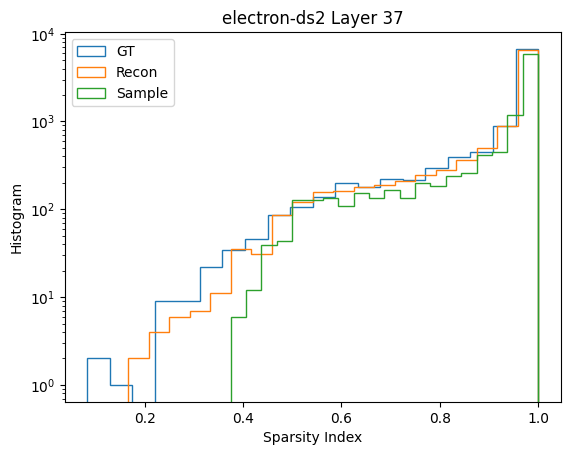

Layer  38 144  voxels


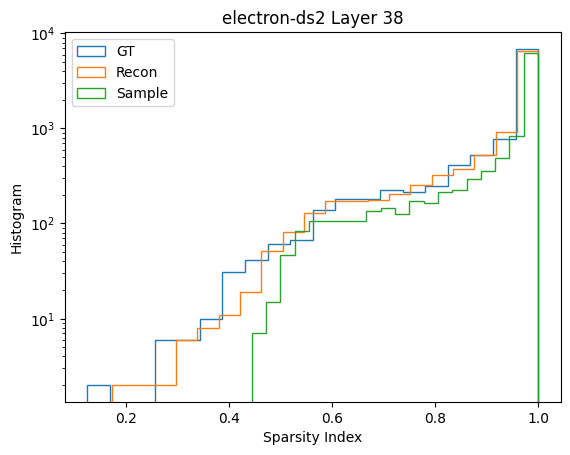

Layer  39 144  voxels


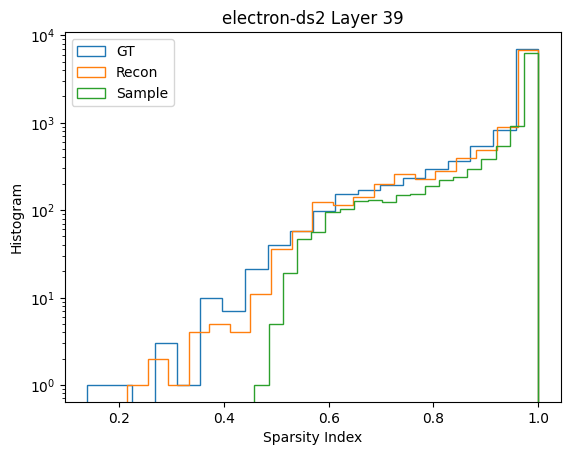

Layer  40 144  voxels


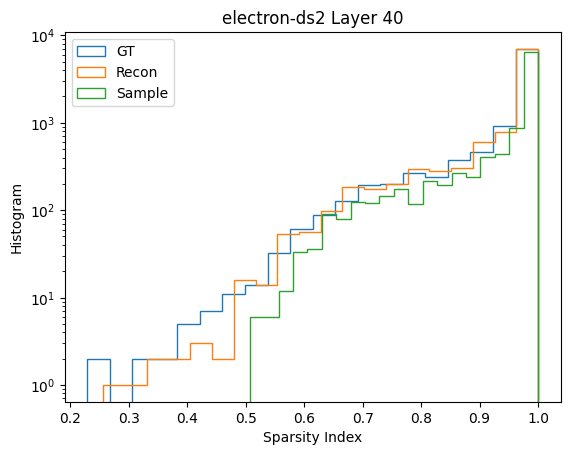

Layer  41 144  voxels


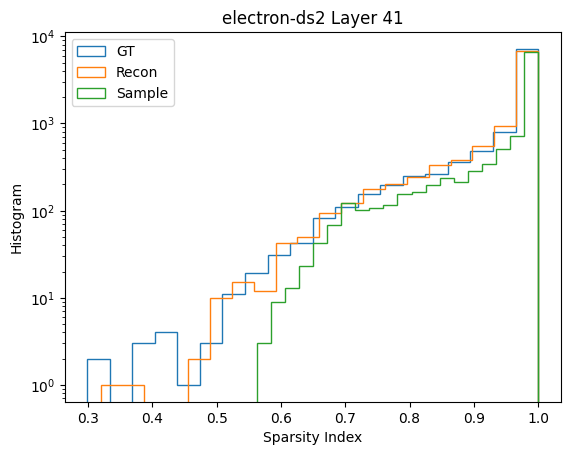

Layer  42 144  voxels


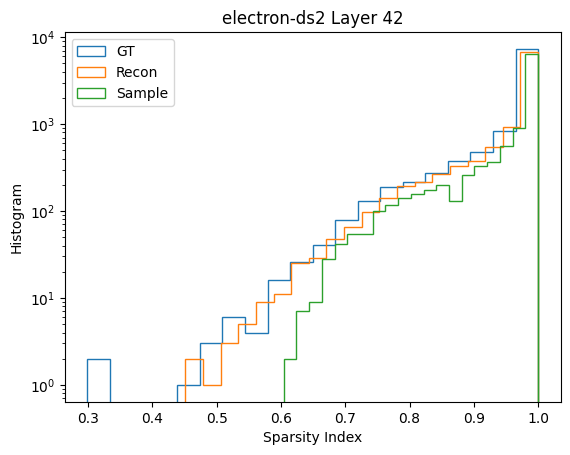

Layer  43 144  voxels


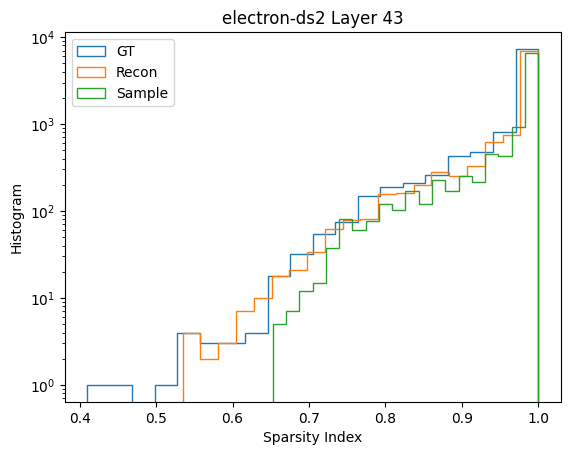

In [39]:
idxPrev = 0
#for i,idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
for i, idx in enumerate([16*9*i for i in range(1, 45)]):
# for i,idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
    l = idx - idxPrev
    print('Layer ', i, l, ' voxels')
    plt.hist(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step')
    plt.hist(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step')
    plt.hist(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step')
    plt.xlabel("Sparsity Index")
    plt.ylabel("Histogram")
    plt.legend(["GT", "Recon", "Sample"])
    plt.title(f'{part} Layer {i}')
    # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
    plt.show()
    idxPrev = idx

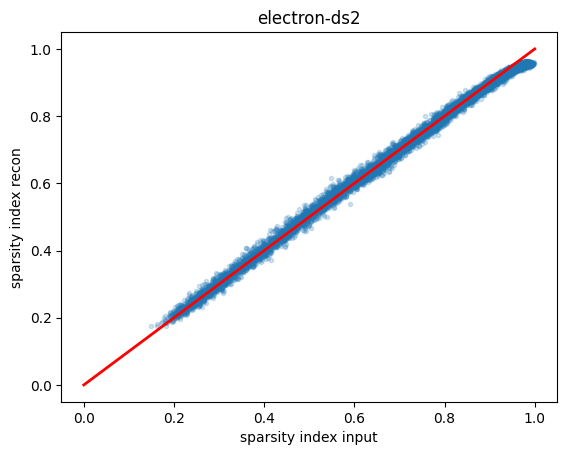

In [40]:
plt.scatter(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), ((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(),  marker='.', alpha=.2)
plt.plot([0,1],[0,1], c='red', lw=2)
plt.xlabel('sparsity index input')
plt.ylabel('sparsity index recon')
plt.title(f'{part}')
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_scatter_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

Layer  0 8  voxels


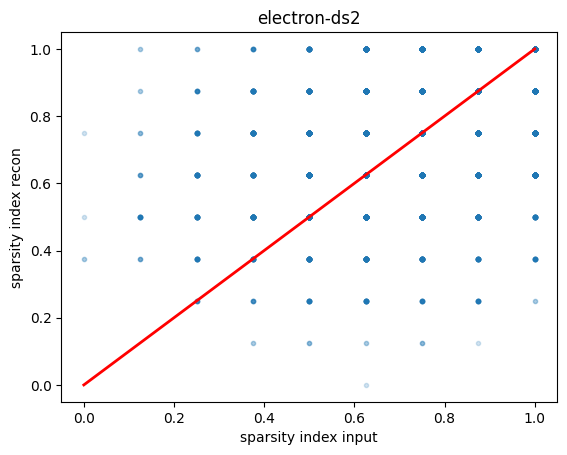

Layer  1 100  voxels


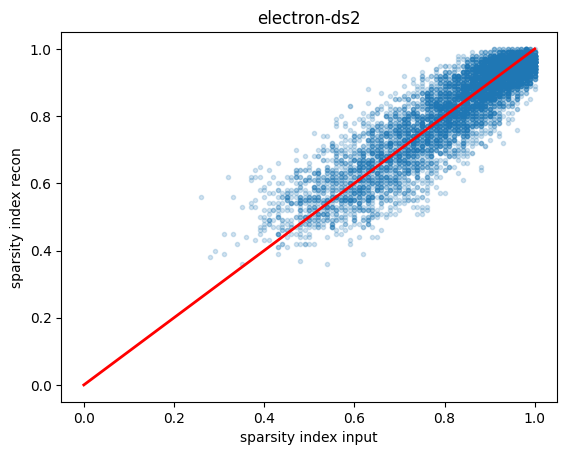

Layer  2 100  voxels


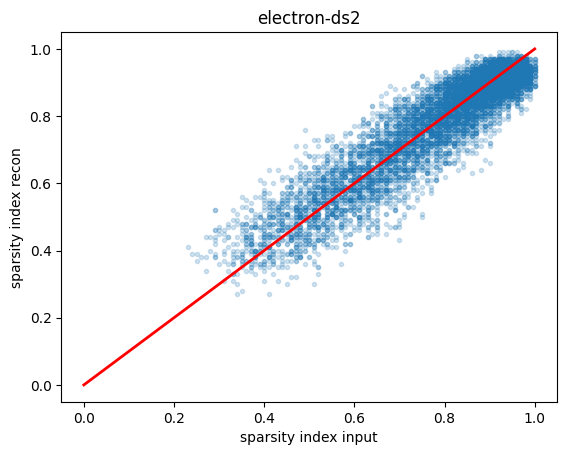

Layer  3 5  voxels


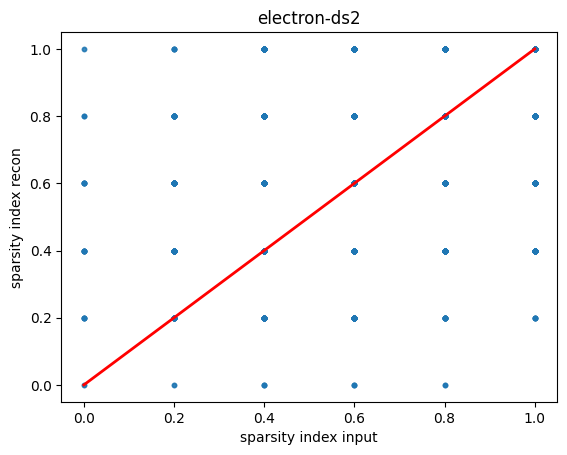

Layer  4 150  voxels


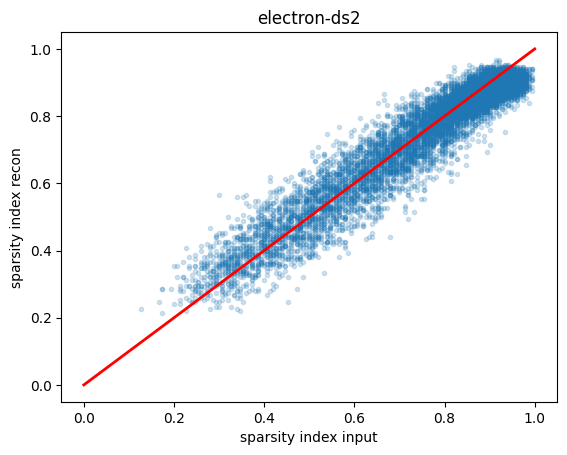

Layer  5 160  voxels


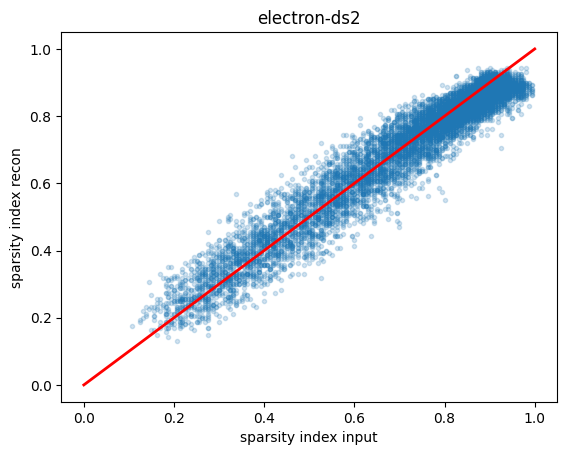

Layer  6 10  voxels


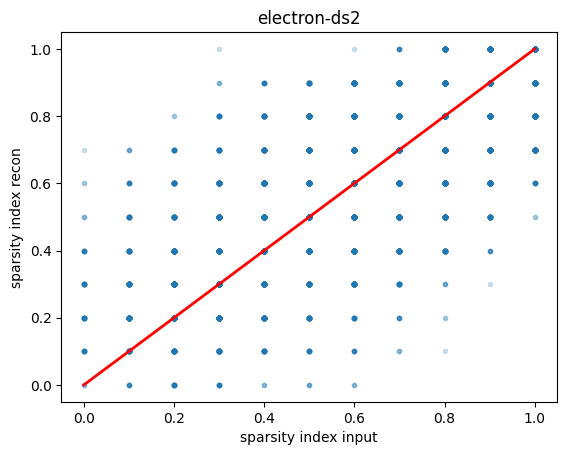

In [41]:
idxPrev = 0
for i, idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
# for i, idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
    l = idx - idxPrev
    print('Layer ', i, l, ' voxels')
    plt.scatter(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), ((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), marker='.', alpha=.2)
    plt.plot([0,1],[0,1], c='red', lw=2)
    plt.xlabel('sparsity index input')
    plt.ylabel('sparsity index recon')
    plt.title(f'{part}')
    # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_scatter_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
    plt.show()
    idxPrev = idx

In [42]:
# xihat_samples.shape
np.unique(HLF_1_photons.bin_edges)

array([  0,   8, 168, 358, 363, 368])

In [43]:
bins = np.arange(0, 10 + 1)
bins

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [44]:
[(i, np.power(2,i)/1000) for i in range(8,23)]

[(8, 0.256),
 (9, 0.512),
 (10, 1.024),
 (11, 2.048),
 (12, 4.096),
 (13, 8.192),
 (14, 16.384),
 (15, 32.768),
 (16, 65.536),
 (17, 131.072),
 (18, 262.144),
 (19, 524.288),
 (20, 1048.576),
 (21, 2097.152),
 (22, 4194.304)]

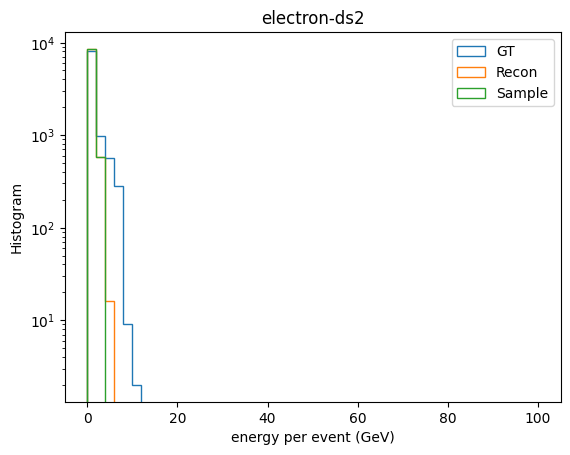

In [55]:
#plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=50, log=True, histtype='step')
#plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=50, log=True, histtype='step')
#plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=50, log=True, histtype='step')
plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step')
plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step')
plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step')
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
plt.xlabel("energy per event (GeV)")
# plt.xscale('log')

plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Sample"])
plt.title(f'{part}')
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

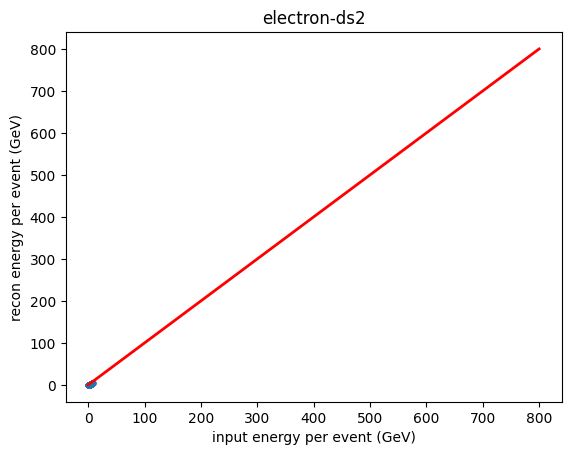

In [46]:
plt.scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.2)
plt.plot([0,800],[0,800], c='red', lw=2)

# sample_data_test = (sam.exp() - 1)*0.04*256*torch.pow(torch.tensor([2]),0)
# plt.hist(np.log(sample_data_test.sum(dim=1).numpy() + 1e-10), bins=10, density=False, alpha=0.7)
plt.xlabel("input energy per event (GeV)")
plt.ylabel("recon energy per event (GeV)")
plt.title(f'{part}')
#plt.yscale('log')
#plt.xscale('log')
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/energy_scatter_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [47]:
# (1 - 0.5 + 0.5*torch.pow(in_data,2))
# in_data

In [48]:
# plt.hist(xitarget_samples.sum(dim=1).numpy(), bins=50, log=True, histtype='step')
# plt.hist(xirecon_samples.sum(dim=1).numpy(), bins=50, log=True, histtype='step')
# plt.hist(xihat_samples.sum(dim=1).numpy(), bins=50, log=True, histtype='step')
# plt.xlabel("ξ per event")
# plt.ylabel("PDF")
# plt.legend(["GT", "Recon", "Sample"])
# plt.title("Pions")
# plt.show()
# [16*9*i for i in range(1,46)]

Layer  0 144  voxels


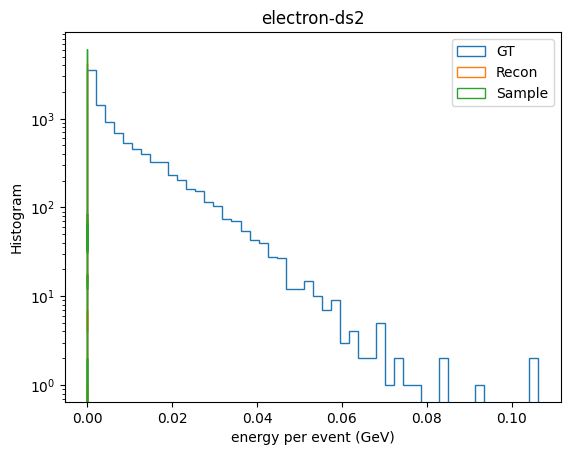

Layer  1 144  voxels


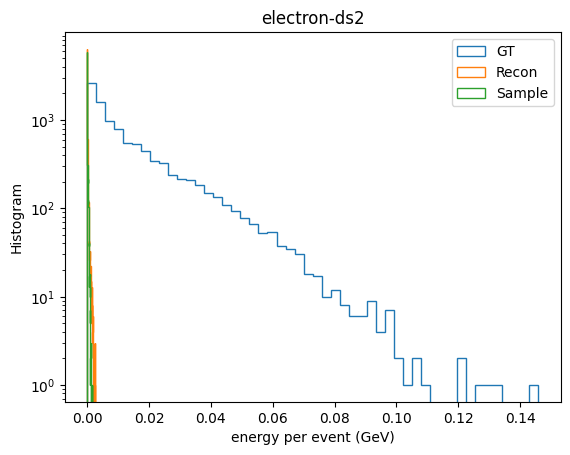

Layer  2 144  voxels


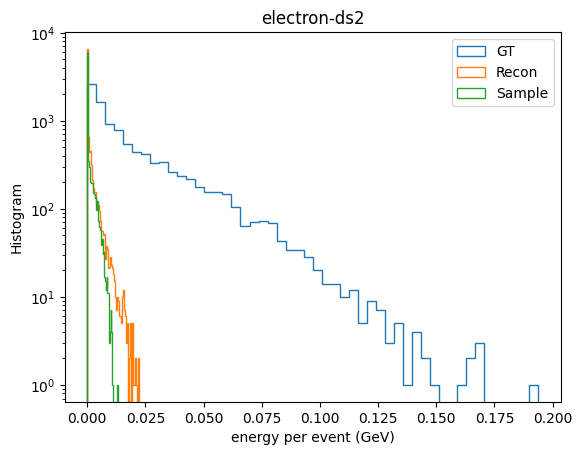

Layer  3 144  voxels


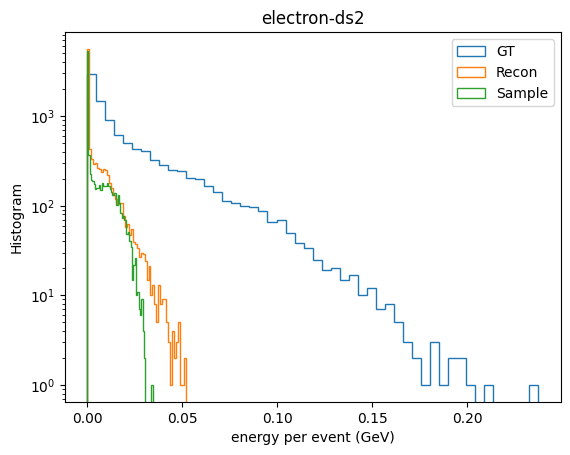

Layer  4 144  voxels


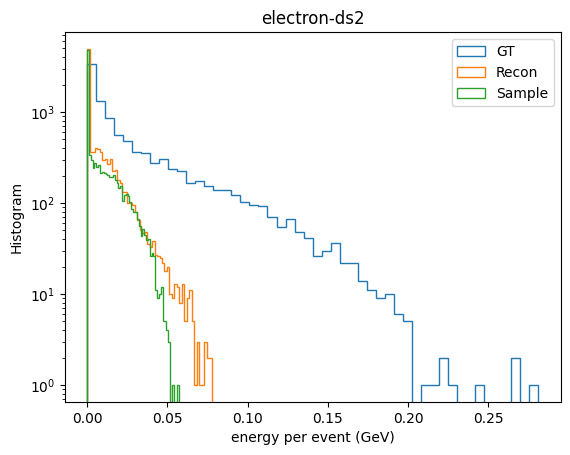

Layer  5 144  voxels


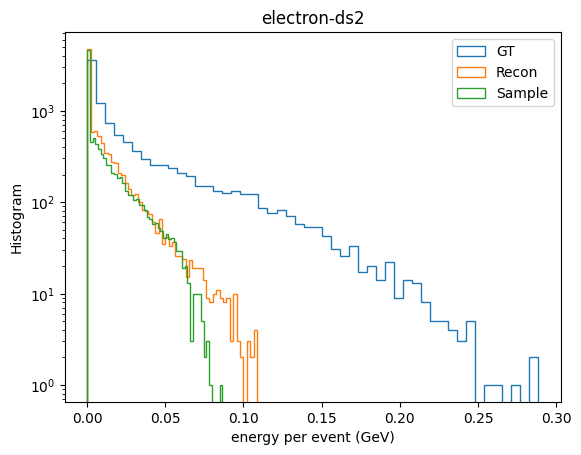

Layer  6 144  voxels


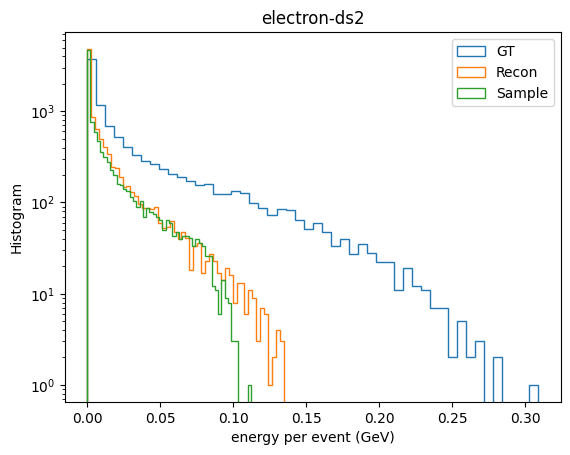

Layer  7 144  voxels


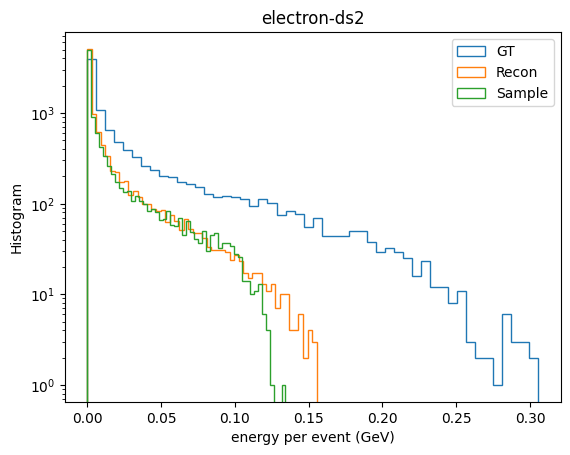

Layer  8 144  voxels


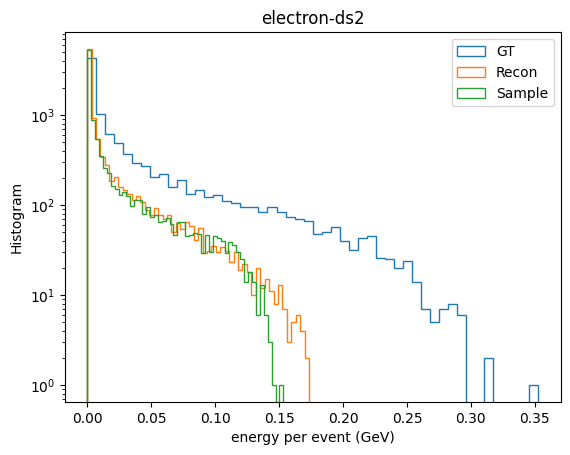

Layer  9 144  voxels


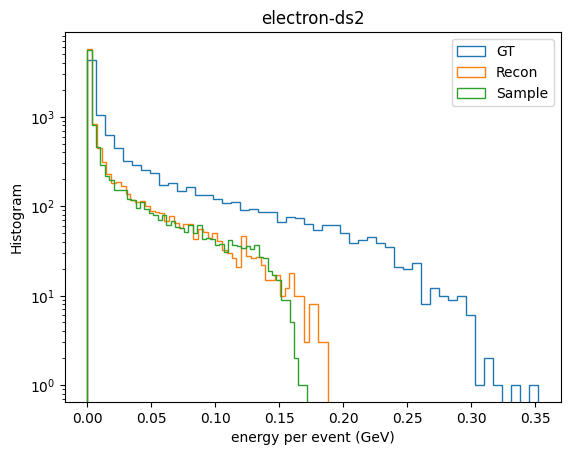

Layer  10 144  voxels


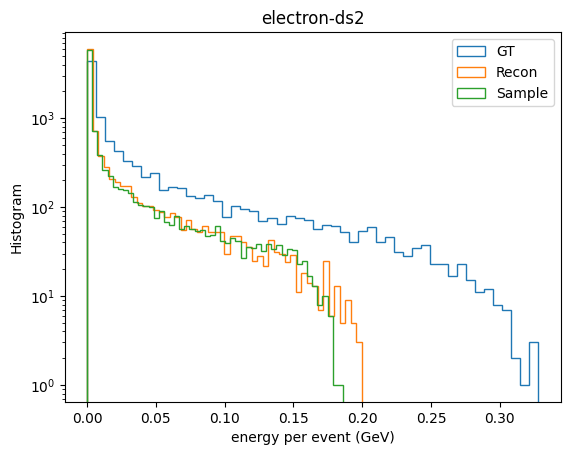

Layer  11 144  voxels


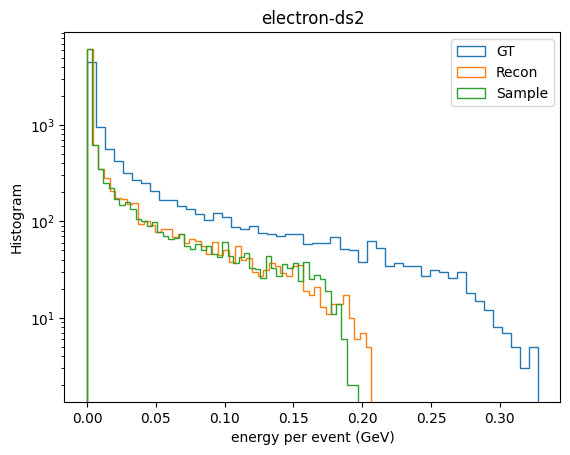

Layer  12 144  voxels


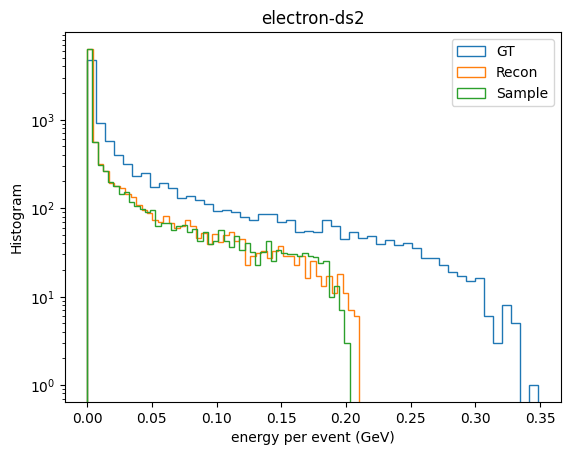

Layer  13 144  voxels


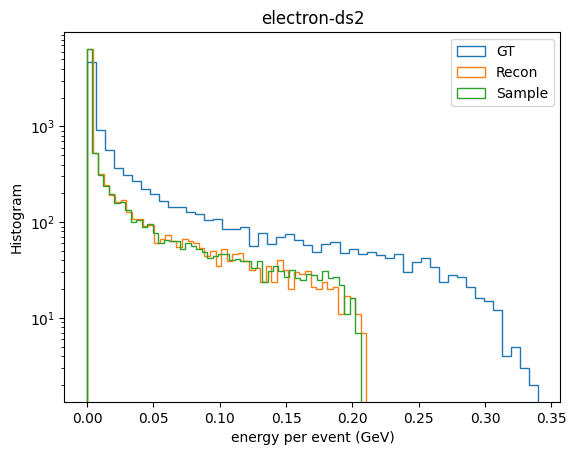

Layer  14 144  voxels


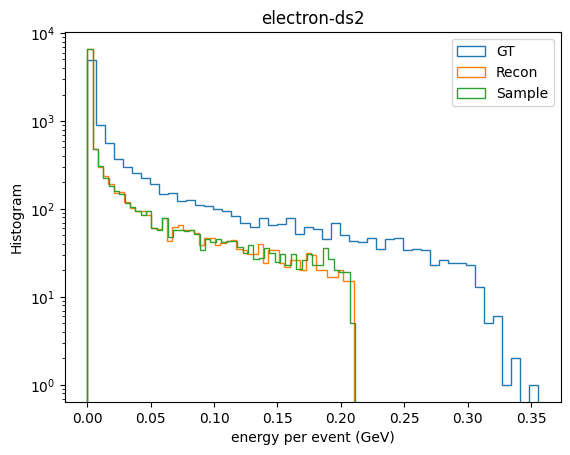

Layer  15 144  voxels


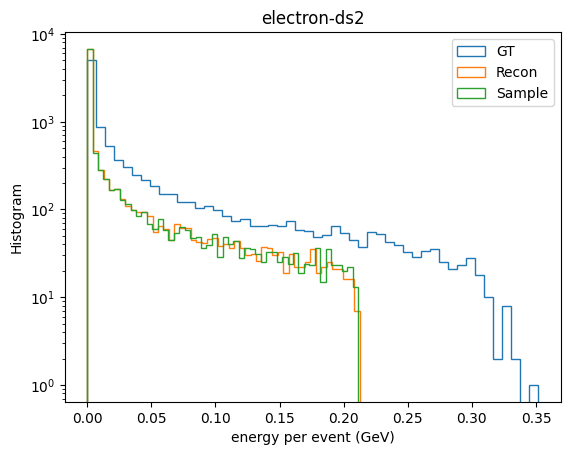

Layer  16 144  voxels


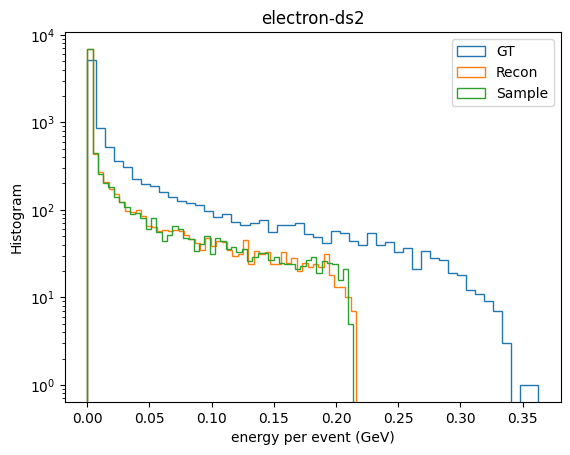

Layer  17 144  voxels


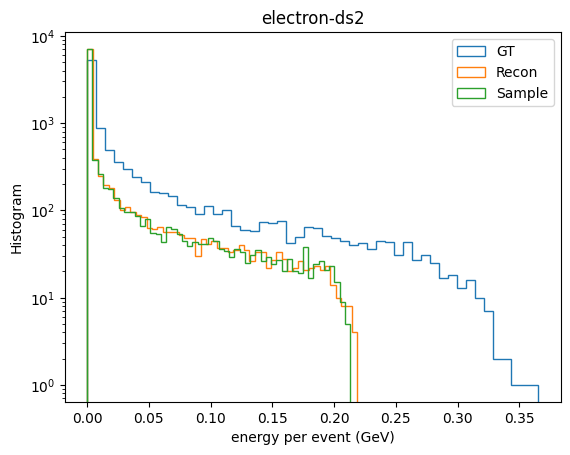

Layer  18 144  voxels


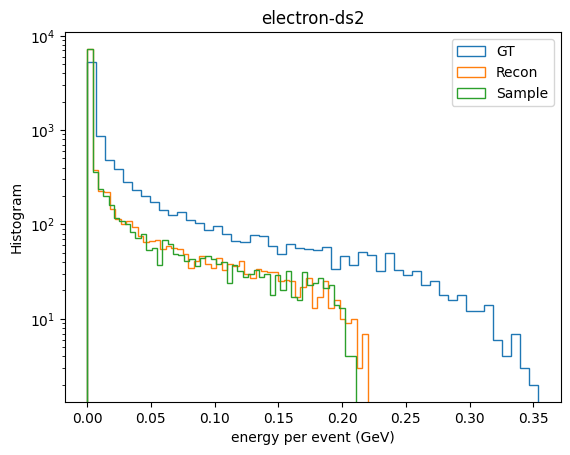

In [49]:
idxPrev = 0
# for i, idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
for i, idx in enumerate([16*9*i for i in range(1,20)]):
# for i, idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
    l = idx - idxPrev
    print('Layer ', i, l, ' voxels')
    # plt.hist(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1), log=True, histtype='step')
    # plt.hist(xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1), log=True, histtype='step')
    # plt.hist(xgen_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1), log=True, histtype='step')
    plt.hist(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=50, log=True, histtype='step')
    plt.hist(xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=50, log=True, histtype='step')
    plt.hist(xgen_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=50, log=True, histtype='step')
    plt.xlabel("energy per event (GeV)")
    plt.ylabel("Histogram")
    plt.legend(["GT", "Recon", "Sample"])
    plt.title(f'{part}')
    # # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/energy_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
    plt.show()
    idxPrev = idx

Layer  0 1440  voxels


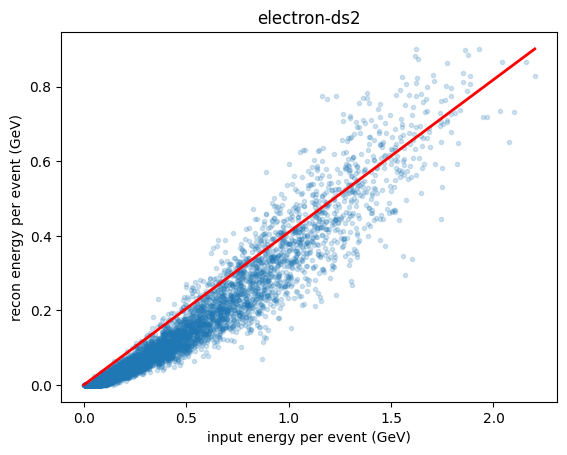

Layer  1 144  voxels


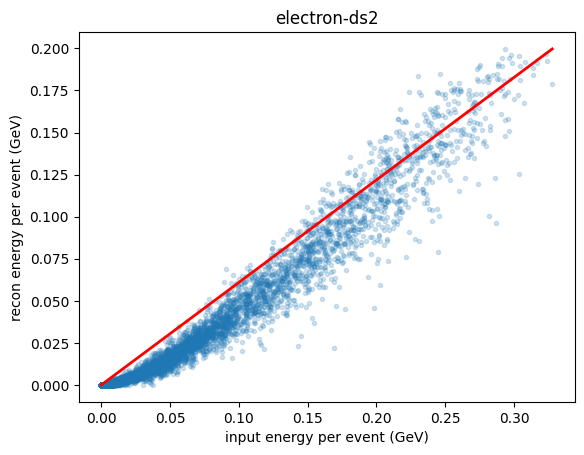

Layer  2 144  voxels


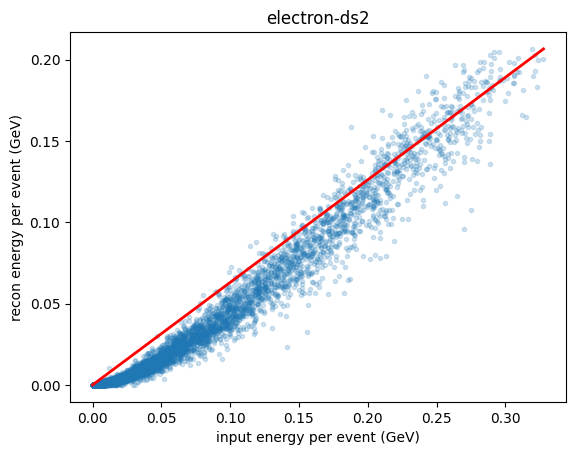

Layer  3 144  voxels


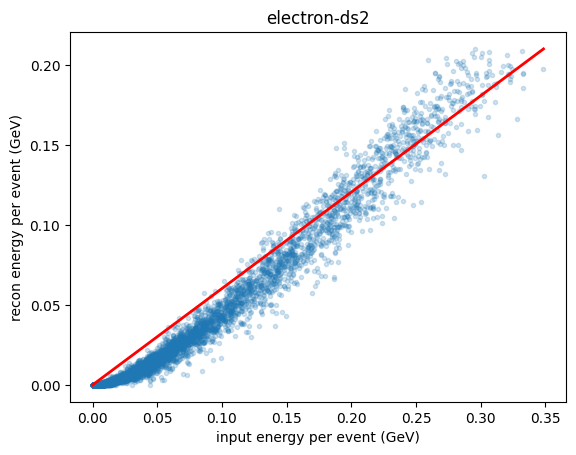

Layer  4 144  voxels


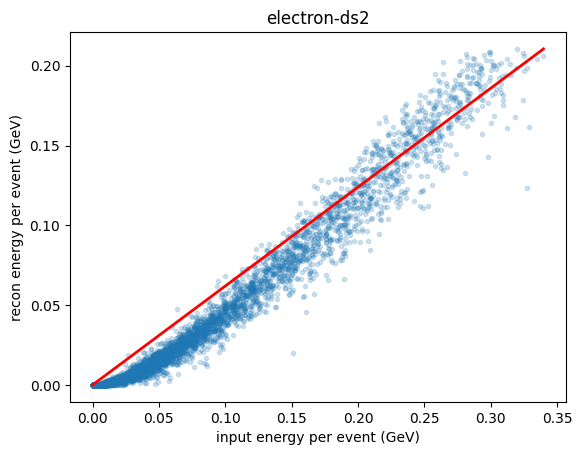

Layer  5 144  voxels


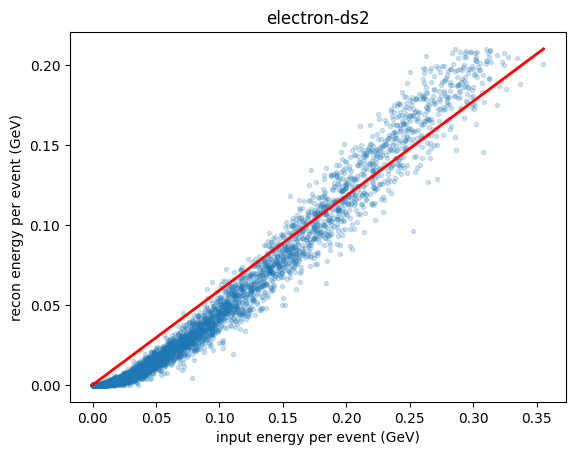

Layer  6 144  voxels


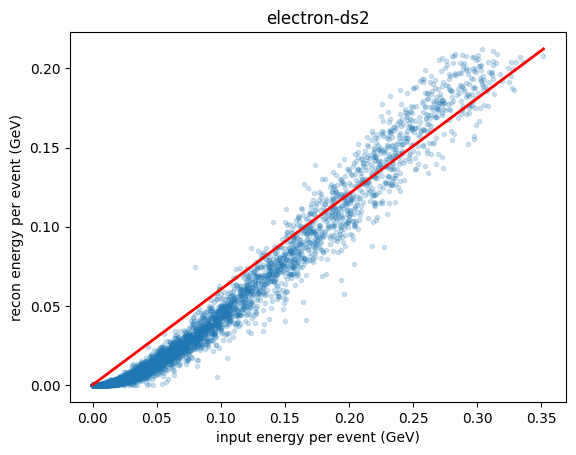

Layer  7 144  voxels


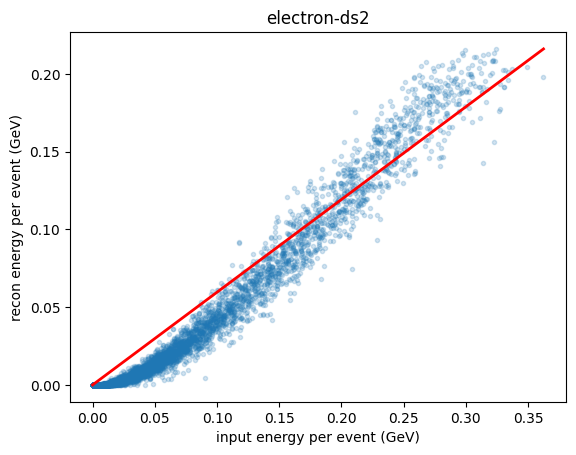

Layer  8 144  voxels


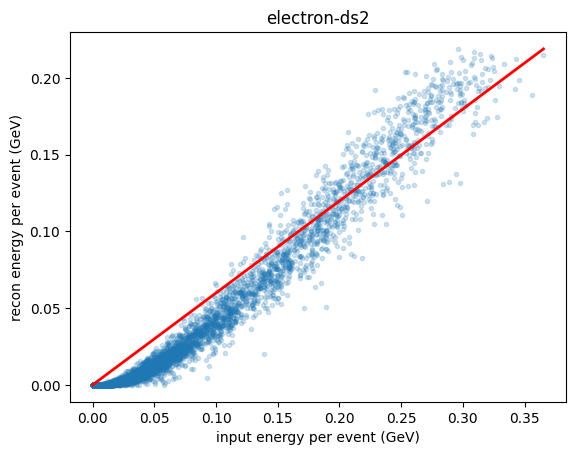

Layer  9 144  voxels


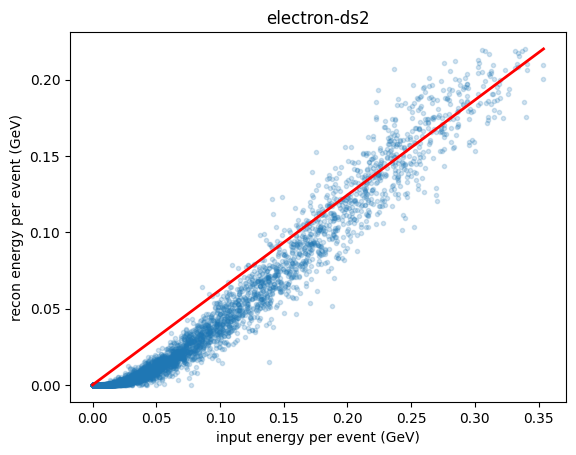

In [50]:
idxPrev = 0
# for i, idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
for i, idx in enumerate([16*9*i for i in range(10,20)]):
# for i, idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
    l = idx - idxPrev
    print('Layer ', i, l, ' voxels')
    plt.scatter(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, marker='.', alpha=.2)
    plt.plot([0,xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy().max()/1000],[0,xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy().max()/1000], c='red', lw=2)
    
    plt.xlabel("input energy per event (GeV)")
    plt.ylabel("recon energy per event (GeV)")
    plt.title(f'{part}')
    # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/energy_scatter_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
    plt.show()
    idxPrev = idx

In [51]:
np.unique(HLF_1_pions.bin_edges)

array([  0,   8, 108, 208, 213, 363, 523, 533])

In [52]:
xx = next(iter(val_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

In [53]:
if reducedata:
    in_data = engine._reduce(in_data, true_energy, R=R)
fwd_output = engine.model((in_data, true_energy), False)
if reducedata:
    in_data = engine._reduceinv(in_data, true_energy, R=R)
    recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
    sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
    sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
elif scaled:
    in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
    recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
    engine._model.sampler._batch_size = true_energy.shape[0]
    # try:
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    # except:
        # pass
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
    sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))

In [24]:
HLF_1_pions.relevantLayers = [1,2,3,4,5,6,7]

In [41]:
HLF_1_electron.relevantLayers = [5,10,15,30,35]

In [42]:
# (((in_data[:,0:108] - recon_data[:,0:108])/(in_data[:,0:108]))**2).sum(dim=1).argsort()[:20]
(((in_data - recon_data)/in_data)**2).sum(dim=1).argsort()[:20]
# (((in_data - recon_data))**2).sum(dim=1).argsort()[:20]

tensor([972, 204,  55, 542, 985, 499, 946,  70, 137,   0,   1,   2,   3,   4,
          5,   6,   7,   8,   9,  10], device='cuda:0')

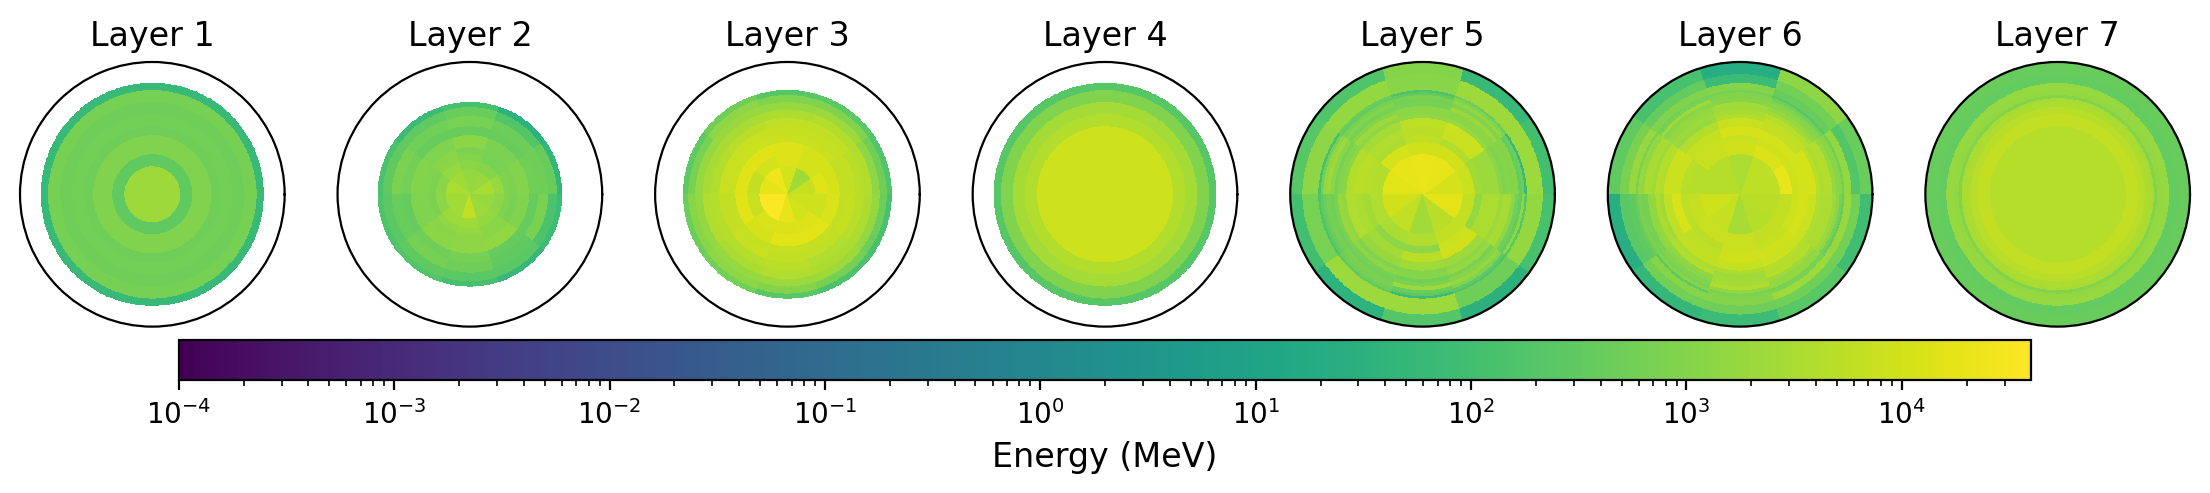

In [43]:
idx=204
HLF_1_pions.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=None)

# HLF_1_pions.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), 
                             # filename=f'/home/javier/Projects/CaloQVAE/figs/target_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
# HLF_1_electron.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), 
#                                 filename=f'/home/javier/Projects/CaloQVAE/figs/target_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
# HLF_1_electron.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), 
#                                 filename=None)


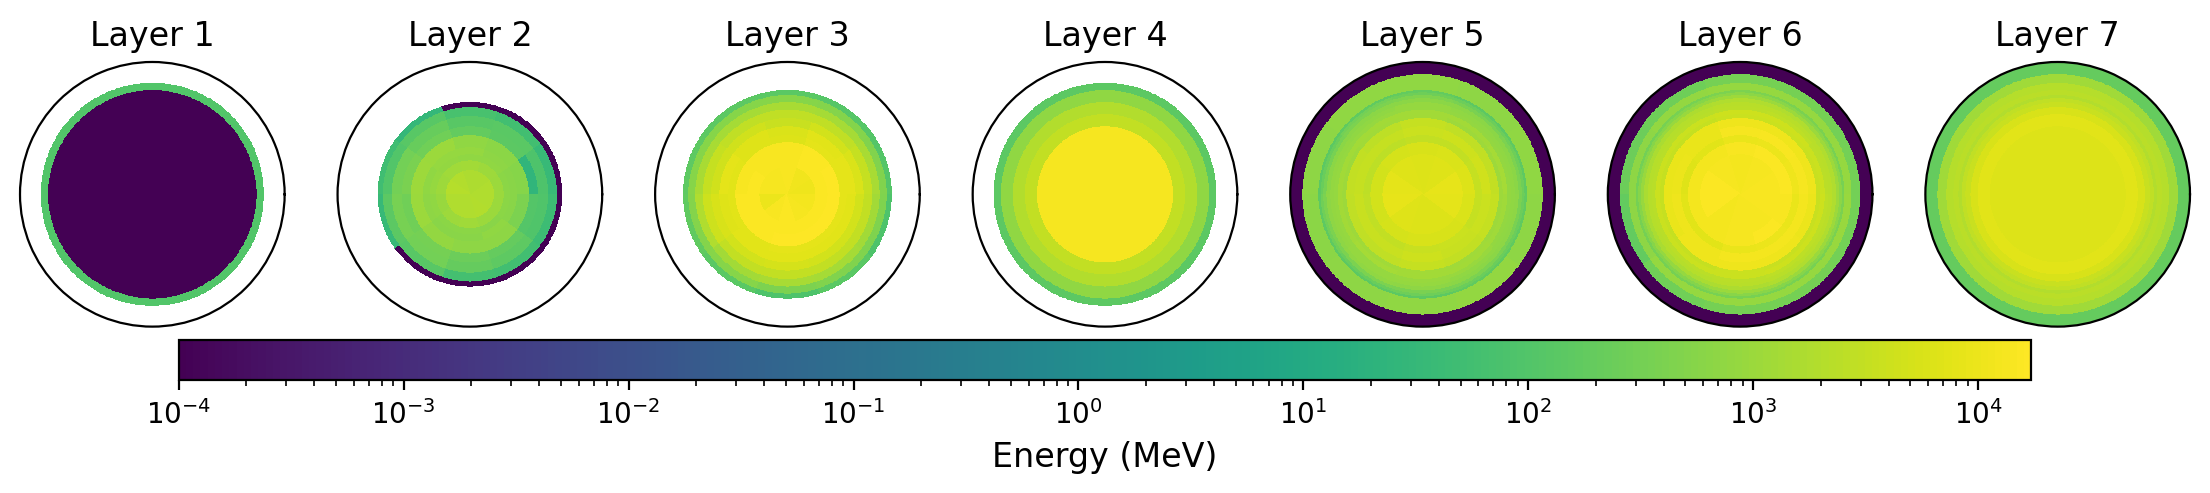

In [44]:
HLF_1_pions.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=None)
# HLF_1_pions.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), 
#                              filename=f'/home/javier/Projects/CaloQVAE/figs/recon_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
# HLF_1_electron.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), 
#                                 filename=f'/home/javier/Projects/CaloQVAE/figs/recon_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
# HLF_1_electron.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), 
#                                 filename=None)


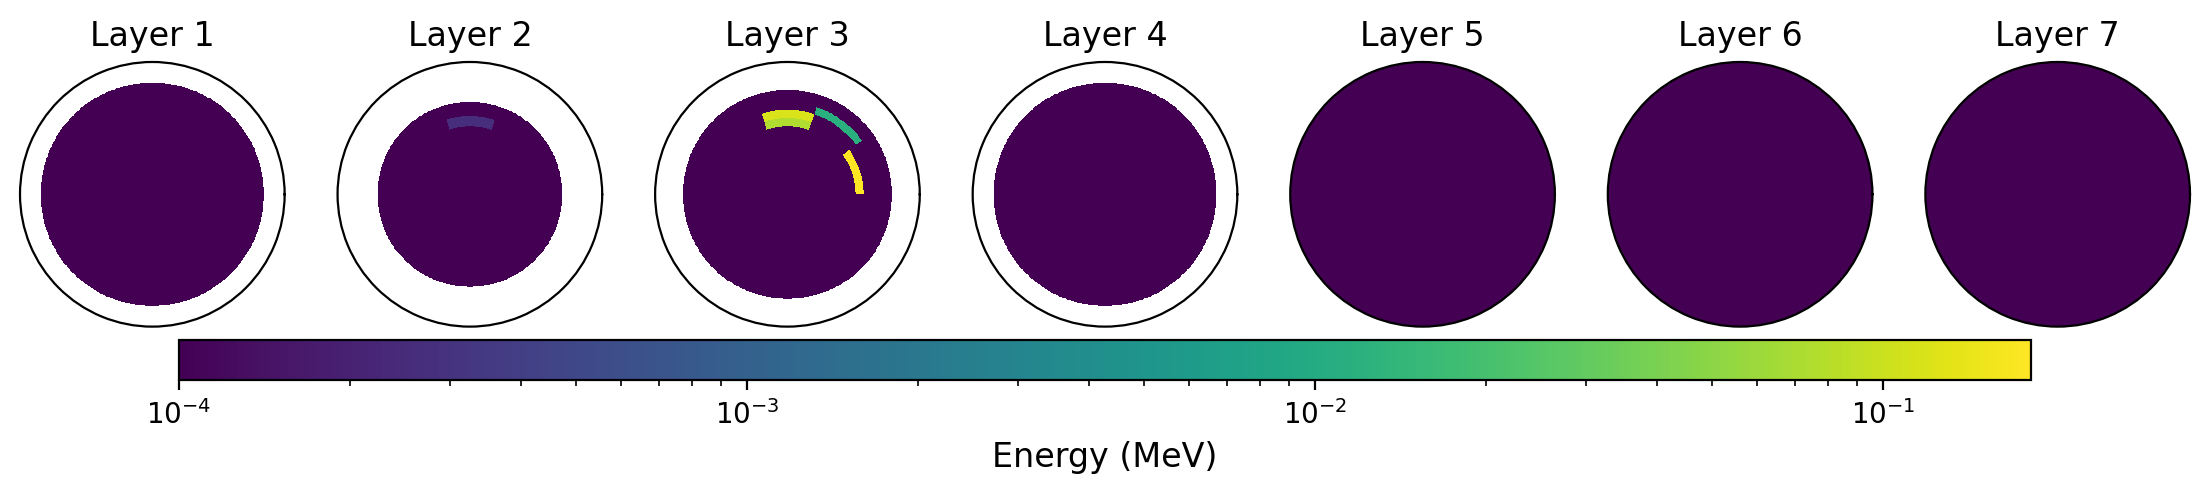

In [45]:
HLF_1_pions.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), filename=None)
# HLF_1_pions.DrawSingleShower(sample_data[1,:].detach().cpu().numpy(), 
#                              filename=f'/home/javier/Projects/CaloQVAE/figs/sample_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
# HLF_1_electron.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), 
                             # filename=f'/home/javier/Projects/CaloQVAE/figs/sample_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
# HLF_1_electron.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), 
#                              filename=None)

In [ ]:
# Gen synth data

In [51]:
import h5py

In [52]:
ef = h5py.File('/raid/javier/Datasets/CaloVAE/data/atlas_dataset2and3/dataset_2_1.hdf5', 'r')

In [54]:
ef["showers"]

<HDF5 dataset "showers": shape (100000, 6480), type "<f8">

(array([684.,  89.,  70.,  45.,  40.,  29.,  21.,  19.,  14.,  13.]),
 array([  1.01109469, 100.08539581, 199.15969849, 298.23397827,
        397.30828857, 496.38259888, 595.45690918, 694.53118896,
        793.60546875, 892.67980957, 991.75408936]),
 <BarContainer object of 10 artists>)

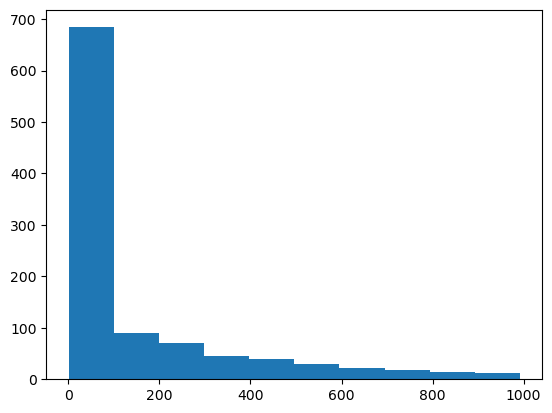

In [57]:
plt.hist(true_energy.detach().cpu().numpy()/1000)

In [62]:
in_data.sum(dim=1)

tensor([  2251.5442,   2548.4956, 197991.8125,  ...,   1088.8044,
         83722.3125,  28762.7969])

In [63]:
true_energy

tensor([[  2128.1135],
        [  3865.5706],
        [256267.9375],
        ...,
        [  1324.8855],
        [110361.2812],
        [ 35360.6562]], device='cuda:0')